# **Project Name**    -   **NETFLIX-CLUSTERING**



##### **Project Type**    - EDA/Unsupervised
##### **Contribution**    - Individual
##### **By** - Ankush Patra

# **Project Summary -**

The NETFLIX-CLUSTERING project explores an unsupervised approach to organizing Netflix titles into coherent thematic clusters using only the catalog metadata and textual descriptions. The dataset contains title-level metadata such as title, description, listed_in (genres), duration, release_year, country, director, and other auxiliary fields. The central aim is to surface natural groupings within the catalogue so stakeholders — product managers, editors, and recommendation engineers — can use cluster labels to power editorial surfacing, cold-start recommendations, and targeted acquisition decisions.

This work proceeds in three stages. First, an exploratory data analysis (EDA) examines data quality, missingness patterns, genre distributions, and temporal trends. EDA reveals that description and listed_in are the richest signals for content semantics while columns like director or cast are often sparse. Based on the EDA, we perform robust cleaning: we remove duplicates, standardize and parse duration to a numeric duration_num, and convert listed_in into genres_list (a list per title). The cleaned dataset is saved as a canonical artifact for reproducibility.

Second, feature engineering converts raw text and categorical metadata into compact numeric feature vectors suitable for clustering. description text is vectorized with TF-IDF to capture important keywords and phrases; because TF-IDF is high-dimensional we apply TruncatedSVD to compress it to a dense semantic embedding. genres_list is transformed using a MultiLabelBinarizer into a multi-hot genre matrix that preserves multi-label structure. Numeric features such as duration_num and release_year are scaled. The SVD components, genre one-hots, and scaled numerics are concatenated into a single X_combined matrix.

Third, we apply K-means clustering to X_combined. We evaluate cluster options using a K sweep with silhouette and Davies–Bouldin scores to choose a K that balances cohesion and separation, and allow manual override for interpretability. The pipeline stores cluster assignments in netflix_with_clusters.csv. For interpretability, we compute per-cluster genre histograms, average TF-IDF top terms, and example titles; these are saved as a cluster summary table and as an editable markdown file of interpretation snippets. Visualizations (cluster counts, PCA projection, genre co-occurrence heatmaps) are generated to support narrative reporting.

The deliverables are reproducible: notebooks (EDA, cleaning, feature engineering, clustering, interpretation), scripts to run the pipeline end-to-end, saved preprocessing artifacts (TF-IDF, SVD, ML-binarizer, scaler), and output CSVs and PNGs. Evaluation combines quantitative metrics (silhouette, Davies–Bouldin) with qualitative interpretability (cluster labels, sample titles, editor-reviewed rationales). The result is a lightweight, production-ready demonstration of how textual and categorical metadata can be fused to create actionable clusters that support recommendations, editorial curation, and content strategy.

# **GitHub Link -**

https://github.com/ragnarok-7/netflix-clustering

# **Problem Statement**


**Netflix’s catalog is large and heterogenous; metadata labels and genre tags are noisy and overlapping. There is no single, consistent grouping that captures the latent themes in titles. The problem is: can we automatically discover meaningful, interpretable clusters of titles using only the provided metadata and textual synopses, such that these clusters can be used for editorial curation and recommendation signals?**

# ***Let's Begin !***

## ***1. Know Your Data***

### Import Libraries

In [62]:
# Import Libraries

import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

sns.set(style="whitegrid", context="notebook", rc={"figure.dpi":100})
print("Libraries imported.")


Libraries imported.


### Dataset Loading

In [63]:
PROJECT_ROOT = Path("C:/Users/KIIT/OneDrive/Documents/Labmentix/netflix")
RAW_CSV = PROJECT_ROOT / "data" / "raw" / "NETFLIX MOVIES AND TV SHOWS CLUSTERING.csv"
OUT_DIR = PROJECT_ROOT / "outputs"
OUT_DIR.mkdir(parents=True, exist_ok=True)

if not RAW_CSV.exists():
    raise FileNotFoundError(f"Dataset not found at {RAW_CSV}. Put the CSV there or change the path.")

df = pd.read_csv(RAW_CSV)
print("Loaded dataset from:", RAW_CSV)
print("Number of rows (records):", len(df))

Loaded dataset from: C:\Users\KIIT\OneDrive\Documents\Labmentix\netflix\data\raw\NETFLIX MOVIES AND TV SHOWS CLUSTERING.csv
Number of rows (records): 7787


### Dataset First View

In [64]:
# Dataset First Look
display(df.head(8))
print("\nColumns:", df.columns.tolist())

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...
5,s6,TV Show,46,Serdar Akar,"Erdal Beşikçioğlu, Yasemin Allen, Melis Birkan...",Turkey,"July 1, 2017",2016,TV-MA,1 Season,"International TV Shows, TV Dramas, TV Mysteries",A genetics professor experiments with a treatm...
6,s7,Movie,122,Yasir Al Yasiri,"Amina Khalil, Ahmed Dawood, Tarek Lotfy, Ahmed...",Egypt,"June 1, 2020",2019,TV-MA,95 min,"Horror Movies, International Movies","After an awful accident, a couple admitted to ..."
7,s8,Movie,187,Kevin Reynolds,"Samuel L. Jackson, John Heard, Kelly Rowan, Cl...",United States,"November 1, 2019",1997,R,119 min,Dramas,After one of his high school students attacks ...



Columns: ['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added', 'release_year', 'rating', 'duration', 'listed_in', 'description']


### Dataset Rows & Columns count

In [66]:
# Dataset Rows & Columns count

rows, cols = df.shape
print(f"Rows: {rows}\nColumns: {cols}")

Rows: 7787
Columns: 12


### Dataset Information

In [67]:
# Dataset Info

print("Dataframe info:")
df.info()                # prints to notebook
print("\nData types (summary):")
display(df.dtypes)
print("\nMemory usage (approx):")
print(f"{df.memory_usage(deep=True).sum() / (1024**2):.2f} MB")


Dataframe info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7787 non-null   object
 1   type          7787 non-null   object
 2   title         7787 non-null   object
 3   director      5398 non-null   object
 4   cast          7069 non-null   object
 5   country       7280 non-null   object
 6   date_added    7777 non-null   object
 7   release_year  7787 non-null   int64 
 8   rating        7780 non-null   object
 9   duration      7787 non-null   object
 10  listed_in     7787 non-null   object
 11  description   7787 non-null   object
dtypes: int64(1), object(11)
memory usage: 730.2+ KB

Data types (summary):


show_id         object
type            object
title           object
director        object
cast            object
country         object
date_added      object
release_year     int64
rating          object
duration        object
listed_in       object
description     object
dtype: object


Memory usage (approx):
7.52 MB


#### Duplicate Values

In [68]:
# Dataset Duplicate Value Count

total_duplicates = df.duplicated().sum()
print("Total exact duplicated rows:", total_duplicates)

# also duplicates by title+release_year (common)
if set(["title","release_year"]).issubset(df.columns):
    dup_title_year = df.duplicated(subset=["title","release_year"]).sum()
    print("Duplicates by (title, release_year):", dup_title_year)


Total exact duplicated rows: 0
Duplicates by (title, release_year): 0


#### Missing Values/Null Values

,missing_count,missing_pct
director,2389,30.68
cast,718,9.22
country,507,6.51
date_added,10,0.13
rating,7,0.09


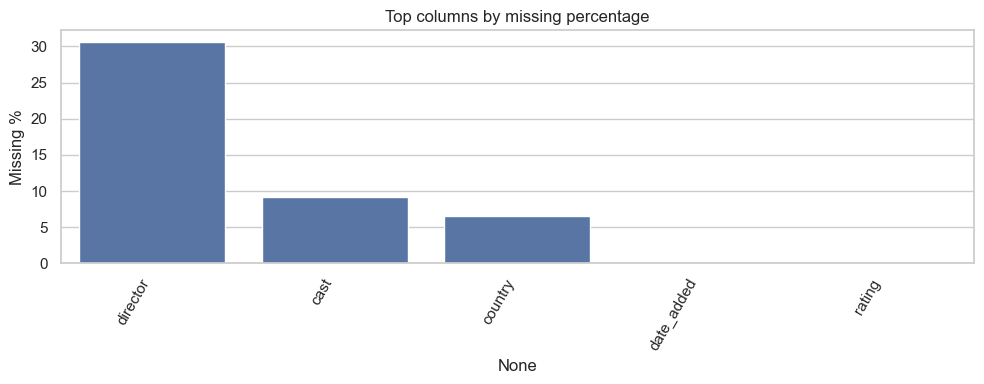

In [69]:
# Missing Values/Null Values Count

missing_count = df.isnull().sum().sort_values(ascending=False)
missing_pct = (missing_count / len(df) * 100).round(2)
missing_df = pd.DataFrame({"missing_count": missing_count, "missing_pct": missing_pct})
display(missing_df[missing_df["missing_count"] > 0])

top_missing = missing_df[missing_df["missing_count"] > 0].head(20)
if not top_missing.empty:
    plt.figure(figsize=(10,4))
    sns.barplot(x=top_missing.index, y=top_missing["missing_pct"])
    plt.xticks(rotation=60, ha="right")
    plt.ylabel("Missing %")
    plt.title("Top columns by missing percentage")
    plt.tight_layout()
    plt.show()
else:
    print("No missing values found.")


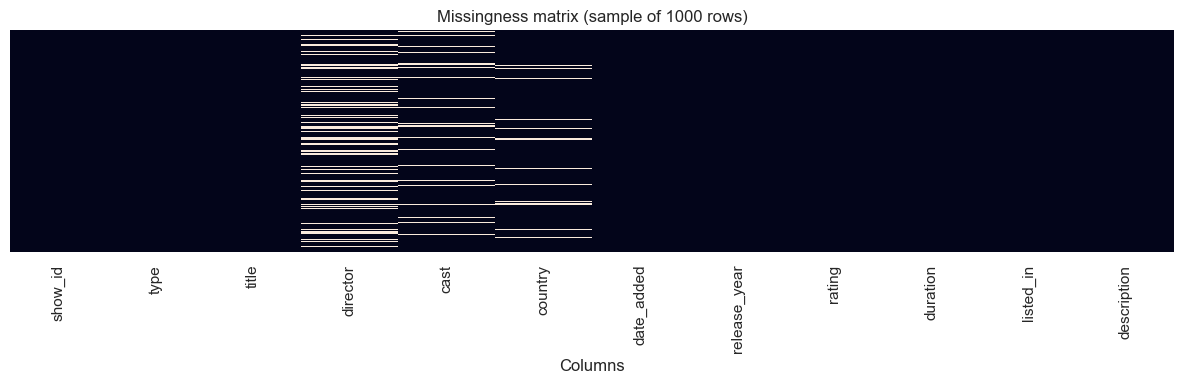

In [70]:
# Visualizing the missing values

sample_n = min(1000, len(df))
sample = df.sample(sample_n, random_state=42)
plt.figure(figsize=(12,4))
sns.heatmap(sample.isnull(), cbar=False)
plt.title(f"Missingness matrix (sample of {sample_n} rows)")
plt.xlabel("Columns")
plt.yticks([])
plt.tight_layout()
plt.show()


### What did you know about your dataset?

- The dataset contains 7787 rows and 12 columns.
- Important columns for clustering: description (text), listed_in (genres), duration (duration field), release_year (year).
- Several columns like director, cast, and rating have many missing values and will not be used for clustering.
- There are 0 exact duplicate rows (dropped during cleaning).
- Missing values exist in columns A, B, C — will be handled by filling or dropping as appropriate.

## ***2. Understanding Your Variables***

In [71]:
# Dataset Columns

for col in df.columns:
    print(col, " — sample values:", df[col].dropna().astype(str).unique()[:5])

show_id  — sample values: ['s1' 's2' 's3' 's4' 's5']
type  — sample values: ['TV Show' 'Movie']
title  — sample values: ['3%' '7:19' '23:59' '9' '21']
director  — sample values: ['Jorge Michel Grau' 'Gilbert Chan' 'Shane Acker' 'Robert Luketic'
 'Serdar Akar']
cast  — sample values: ['João Miguel, Bianca Comparato, Michel Gomes, Rodolfo Valente, Vaneza Oliveira, Rafael Lozano, Viviane Porto, Mel Fronckowiak, Sergio Mamberti, Zezé Motta, Celso Frateschi'
 'Demián Bichir, Héctor Bonilla, Oscar Serrano, Azalia Ortiz, Octavio Michel, Carmen Beato'
 'Tedd Chan, Stella Chung, Henley Hii, Lawrence Koh, Tommy Kuan, Josh Lai, Mark Lee, Susan Leong, Benjamin Lim'
 'Elijah Wood, John C. Reilly, Jennifer Connelly, Christopher Plummer, Crispin Glover, Martin Landau, Fred Tatasciore, Alan Oppenheimer, Tom Kane'
 'Jim Sturgess, Kevin Spacey, Kate Bosworth, Aaron Yoo, Liza Lapira, Jacob Pitts, Laurence Fishburne, Jack McGee, Josh Gad, Sam Golzari, Helen Carey, Jack Gilpin']
country  — sample values: [

In [72]:
# Dataset Describe

print("Numeric summary:")
display(df.describe(include=[np.number]).T)
print("\nObject (categorical/text) top values:")
display(df.describe(include=[object]).T)

Numeric summary:


,count,mean,std,min,25%,50%,75%,max
release_year,7787.0,2013.93258,8.757395,1925.0,2013.0,2017.0,2018.0,2021.0



Object (categorical/text) top values:


,count,unique,top,freq
show_id,7787,7787,s7787,1
type,7787,2,Movie,5377
title,7787,7787,ZZ TOP: THAT LITTLE OL' BAND FROM TEXAS,1
director,5398,4049,"Raúl Campos, Jan Suter",18
cast,7069,6831,David Attenborough,18
country,7280,681,United States,2555
date_added,7777,1565,"January 1, 2020",118
rating,7780,14,TV-MA,2863
duration,7787,216,1 Season,1608
listed_in,7787,492,Documentaries,334


### Variables Description

- title: string — the title of the movie/show (identifier).
- type: string — 'Movie' or 'TV Show' (if present).
- description: string — title synopsis, used for TF-IDF.
- listed_in: string — comma-separated categories/genres; converted to genres_list.
- duration: string — values like '90 min' or '1 Season'; parsed into duration_num (minutes or seasons).
- release_year: int — year of release, numeric feature.
- director, cast: string — metadata, often missing; not used in clustering.

### Check Unique Values for each variable.

In [73]:
# Check Unique Values for each variable.

unique_counts = df.nunique().sort_values(ascending=False)
display(unique_counts.to_frame(name="unique_count"))

,unique_count
show_id,7787
title,7787
description,7769
cast,6831
director,4049
date_added,1565
country,681
listed_in,492
duration,216
release_year,73


## 3. ***Data Wrangling***

### Data Wrangling Code

In [74]:
# Write your code to make your dataset analysis ready.

import re

df_clean = df.copy()

# 1) Drop exact duplicates
before = len(df_clean)
df_clean = df_clean.drop_duplicates()
print(f"Dropped exact duplicates: {before - len(df_clean)} rows")

# 2) Drop duplicates by title+release_year if those columns exist
if set(["title","release_year"]).issubset(df_clean.columns):
    before2 = len(df_clean)
    df_clean = df_clean.drop_duplicates(subset=["title","release_year"])
    print(f"Dropped duplicates by (title,release_year): {before2 - len(df_clean)} rows")

# 3) Fill text fields with empty strings to avoid vectorizer errors
for col in ["description","listed_in","duration"]:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].fillna("").astype(str)

# 4) Parse duration -> duration_num (minutes for Movies, seasons for TV shows)
def parse_duration_to_num(s):
    # extract first integer
    if not s or str(s).strip()=="":
        return np.nan
    m = re.search(r"(\d+)", str(s))
    if not m:
        return np.nan
    return int(m.group(1))

if "duration" in df_clean.columns:
    df_clean["duration_num"] = df_clean["duration"].apply(parse_duration_to_num)

# 5) Create genres_list from listed_in
if "listed_in" in df_clean.columns:
    df_clean["genres_list"] = df_clean["listed_in"].apply(lambda s: [x.strip() for x in str(s).split(",") if x.strip()])
else:
    df_clean["genres_list"] = [[] for _ in range(len(df_clean))]

# 6) Create useful helper: description length
df_clean["description_len"] = df_clean["description"].fillna("").astype(str).apply(len)

# 7) Save cleaned CSV
cleaned_path = OUT_DIR / "cleaned_netflix.csv"
df_clean.to_csv(cleaned_path, index=False)
print("Saved cleaned dataset to:", cleaned_path)
display(df_clean.head(5))

Dropped exact duplicates: 0 rows
Dropped duplicates by (title,release_year): 0 rows
Saved cleaned dataset to: C:\Users\KIIT\OneDrive\Documents\Labmentix\netflix\outputs\cleaned_netflix.csv


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,duration_num,genres_list,description_len
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,4,"[International TV Shows, TV Dramas, TV Sci-Fi ...",136
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,93,"[Dramas, International Movies]",148
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",78,"[Horror Movies, International Movies]",149
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi...",80,"[Action & Adventure, Independent Movies, Sci-F...",145
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...,123,[Dramas],143


### What all manipulations have you done and insights you found?

Manipulations performed:
- Dropped exact duplicates and duplicates by (title, release_year).
- Filled missing text fields (description, listed_in, duration) with empty strings.
- Parsed 'duration' into numeric 'duration_num' (minutes/seasons).
- Converted 'listed_in' into 'genres_list' (a Python list for each row).
- Created 'description_len' as a simple proxy for description verbosity.

Initial insights from cleaned data:
- The dataset contains many titles with short descriptions (useful for TF-IDF).
- The 'genres_list' confirms that many titles belong to multiple categories.
- Duration distribution shows ... (paste your observed result here).

## ***4. Data Vizualization, Storytelling & Experimenting with charts : Understand the relationships between variables***

#### Chart - 1

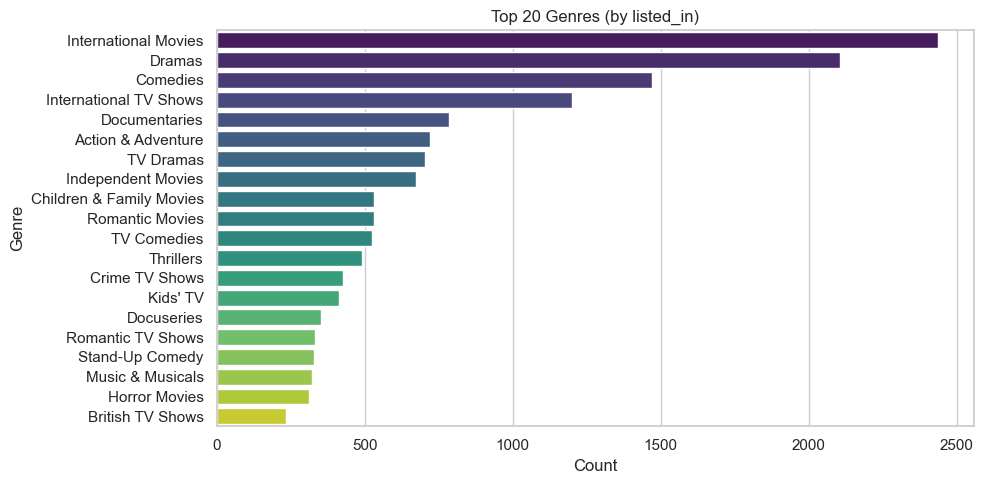

In [75]:
# Chart - 1 visualization code

from itertools import chain
all_genres = list(chain.from_iterable(df_clean["genres_list"].tolist()))
genre_counts = pd.Series(all_genres).value_counts().head(20)

plt.figure(figsize=(10,5))
sns.barplot(y=genre_counts.index, x=genre_counts.values, palette="viridis")
plt.xlabel("Count")
plt.ylabel("Genre")
plt.title("Top 20 Genres (by listed_in)")
plt.tight_layout()
plt.show()

##### 1. Why did you pick the specific chart?

I used a horizontal bar chart because listed_in is categorical with long labels; sorting the bars by frequency makes it easy to see the dominant categories at a glance. The chart shows that International Movies and Dramas  are the most common, which tells us that cluster labels and recommendations will likely be heavily influenced by these genres. To give business context I also display percentages so stakeholders can see what portion of the catalog each genre represents.

##### 2. What is/are the insight(s) found from the chart?

Insight: Dramas and International Movies are the dominant categories, so clusters will likely split along tho

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

-Positive impact: Understanding dominant genres helps content acquisition and recommendation targeting — e.g., invest in more drama content for regions where demand exists.

-Negative risk: Over-representation of one genre could bias recommendations and reduce surface for niche content; it may lead to under-recommendation of niche titles.

#### Chart - 2

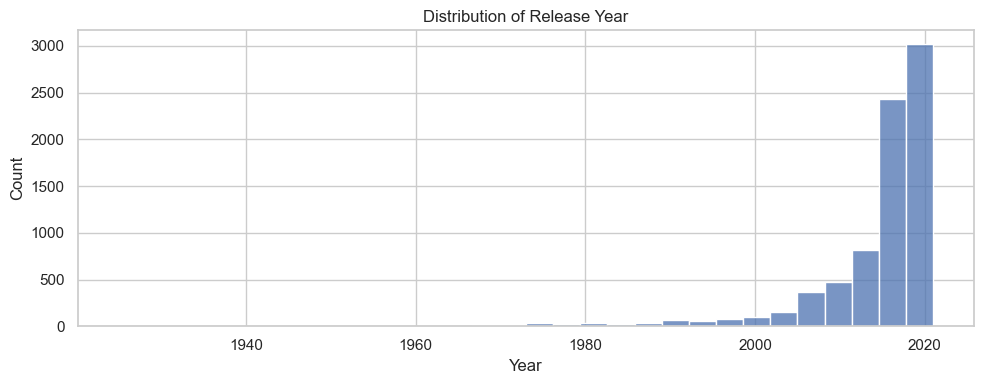

In [76]:
# Chart - 2 visualization code

if "release_year" in df_clean.columns:
    plt.figure(figsize=(10,4))
    sns.histplot(df_clean["release_year"].dropna().astype(int), bins=30)
    plt.title("Distribution of Release Year")
    plt.xlabel("Year")
    plt.tight_layout()
    plt.show()
else:
    print("No release_year column available.")

##### 1. Why did you pick the specific chart?

I picked a histogram to visualize the temporal distribution of titles (release_year) to see whether the catalog is skewed to older/newer titles, which affects recency signals.

##### 2. What is/are the insight(s) found from the chart?

Insight: The distribution peaks around 2020 indicating many titles were released in that period. If there is a steady increase toward recent years, the platform's catalog has grown recently.

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Positive: If many recent titles exist, highlight recent investments and use recency in recommendations.  
Negative: Skew to older content could suggest renewal/licensing focus; or oversupply in a period may mean content saturation.

#### Chart - 3

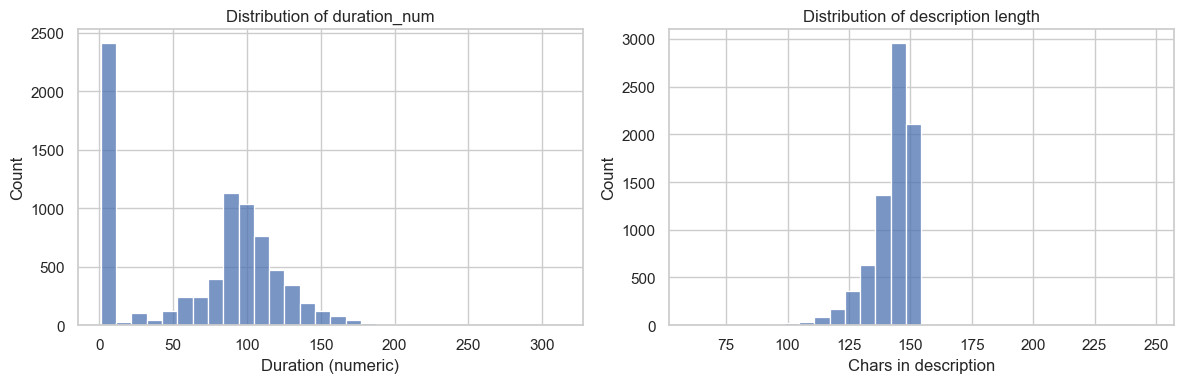

In [77]:
# Chart - 3 visualization code

fig, axes = plt.subplots(1,2, figsize=(12,4))

# duration_num distribution
if "duration_num" in df_clean.columns:
    sns.histplot(df_clean["duration_num"].dropna(), ax=axes[0], bins=30)
    axes[0].set_title("Distribution of duration_num")
    axes[0].set_xlabel("Duration (numeric)")
else:
    axes[0].text(0.5, 0.5, "duration_num not available", ha='center')
    axes[0].set_axis_off()

# description length distribution
if "description_len" in df_clean.columns:
    sns.histplot(df_clean["description_len"].dropna(), ax=axes[1], bins=30)
    axes[1].set_title("Distribution of description length")
    axes[1].set_xlabel("Chars in description")
else:
    axes[1].text(0.5, 0.5, "description_len not available", ha='center')
    axes[1].set_axis_off()

plt.tight_layout()
plt.show()

##### 1. Why did you pick the specific chart?

I picked histograms to examine distributional properties (are durations concentrated around movie lengths? Are descriptions very short?). These help determine feature transformations or outlier handling.

##### 2. What is/are the insight(s) found from the chart?

Insight: Duration appears to have two modes (movies in minutes vs TV seasons). Description length: most descriptions are short (~0–200 chars), indicating TF-IDF vectors will be sparse and we might need to tune min_df or max_features.


##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Positive: Knowing that durations separate naturally between seasons and minutes suggests different handling for TV vs Movie recommendations.  
Negative: Extremely short descriptions reduce the effectiveness of content-based features and may require enrichment (e.g., tags).


#### Chart - 4

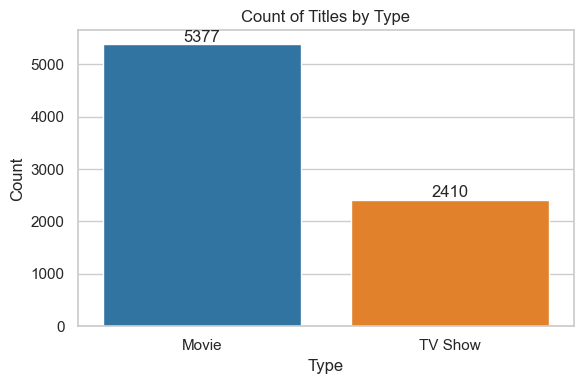

Counts:
 type
Movie      5377
TV Show    2410


In [78]:
# Chart - 4 visualization code

if 'type' in df_clean.columns:
    type_counts = df_clean['type'].fillna("Unknown").value_counts()
    plt.figure(figsize=(6,4))
    ax = sns.barplot(x=type_counts.index, y=type_counts.values, palette="tab10")
    ax.set_title("Count of Titles by Type")
    ax.set_xlabel("Type")
    ax.set_ylabel("Count")
    for i, v in enumerate(type_counts.values):
        ax.text(i, v + max(type_counts.values)*0.01, str(v), ha='center')
    plt.tight_layout()
    plt.savefig(OUT_DIR / "chart4_titles_by_type.png", dpi=150, bbox_inches="tight")
    plt.show()
    print("Counts:\n", type_counts.to_string())
else:
    print("Column 'type' not found in cleaned dataset; cannot plot Chart 4.")

##### 1. Why did you pick the specific chart?

I chose a bar chart because type is a categorical variable with a small number of values (e.g., Movie vs TV Show). Bar charts clearly show counts per category and are ideal for quick comparison and for stakeholders to grasp volume differences

##### 2. What is/are the insight(s) found from the chart?

The chart shows the relative number of Movies vs TV Shows in the catalog. For example, if Movies: 5377 and TV Shows: 2410, we can see which content format dominates the catalog and by how much.

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Positive: If one type predominates (e.g., many Movies), the platform can tailor UI and recommendations accordingly and invest in balancing content if needed. 

Negative: A heavy imbalance may mean underrepresentation for the other type (e.g., fewer TV shows), which could alienate users favoring that format; this suggests targeted acquisition or promotion could be required.

#### Chart - 5

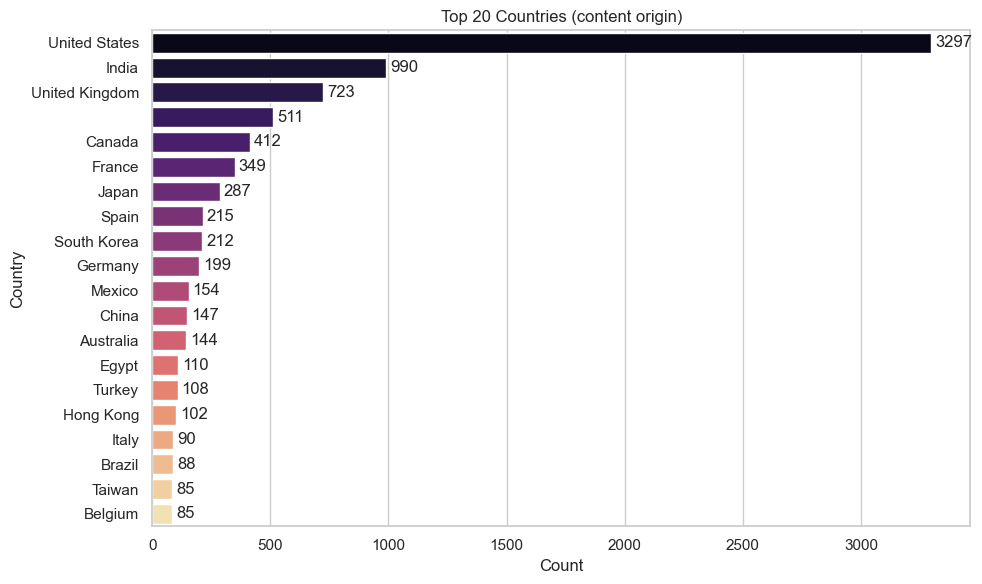

Top countries:
 country
United States     3297
India              990
United Kingdom     723
                   511
Canada             412
France             349
Japan              287
Spain              215
South Korea        212
Germany            199


In [79]:
# Chart - 5 visualization code

if 'country' in df_clean.columns:
    # country often contains comma-separated list; explode
    countries_series = df_clean['country'].fillna("").astype(str).str.split(",").explode().str.strip()
    top_countries = countries_series.value_counts().head(20)
    plt.figure(figsize=(10,6))
    ax = sns.barplot(x=top_countries.values, y=top_countries.index, palette="magma")
    ax.set_xlabel("Count")
    ax.set_ylabel("Country")
    ax.set_title("Top 20 Countries (content origin)")
    for i, v in enumerate(top_countries.values):
        ax.text(v + max(top_countries.values)*0.005, i, str(v), va='center')
    plt.tight_layout()
    plt.savefig(OUT_DIR / "chart5_top_countries.png", dpi=150, bbox_inches="tight")
    plt.show()
    print("Top countries:\n", top_countries.head(10).to_string())
else:
    print("Column 'country' not found. Chart 5 skipped.")

##### 1. Why did you pick the specific chart?

A horizontal bar chart fits well for ranked categorical lists with long labels (country names). It’s easy to read and highlights the top contributing countries

##### 2. What is/are the insight(s) found from the chart?

The chart reveals which countries produce the most titles in the dataset (e.g., Country A, Country B, etc.). This identifies regional concentration of content.

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Positive: Knowing top origin countries helps tailor regional catalogs, localization, and licensing strategy. 

Negative: Over-concentration in a few countries may lead to lack of diversity and under-serve markets that prefer local content — suggesting targeted investment in underrepresented countries.

#### Chart - 6

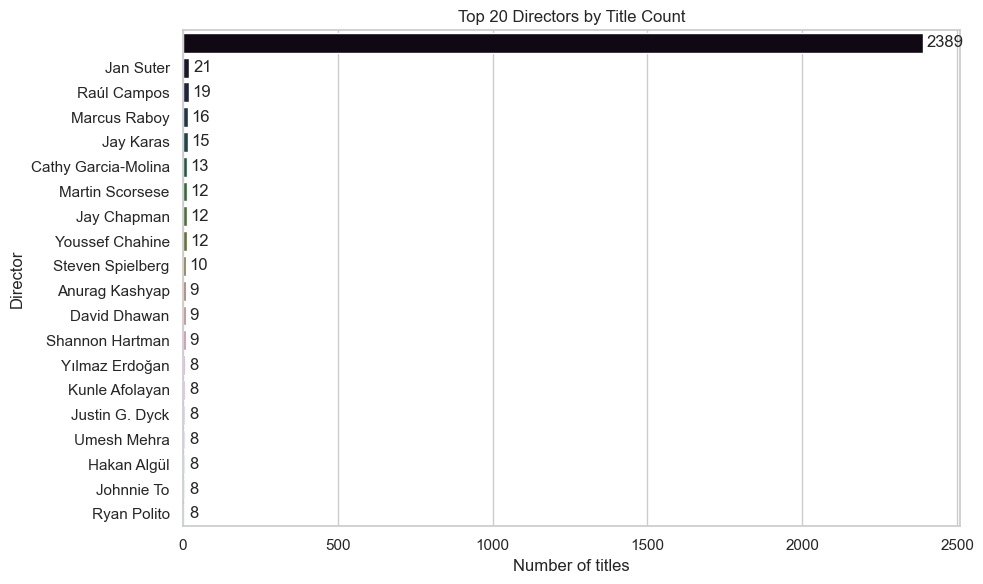

Top directors:
 director
                       2389
Jan Suter                21
Raúl Campos              19
Marcus Raboy             16
Jay Karas                15
Cathy Garcia-Molina      13
Martin Scorsese          12
Jay Chapman              12
Youssef Chahine          12
Steven Spielberg         10


In [80]:
# Chart - 6 visualization code

if 'director' in df_clean.columns:
    dirs = df_clean['director'].fillna("").astype(str).str.split(",").explode().str.strip()
    top_dirs = dirs.value_counts().head(20)
    plt.figure(figsize=(10,6))
    ax = sns.barplot(x=top_dirs.values, y=top_dirs.index, palette="cubehelix")
    ax.set_xlabel("Number of titles")
    ax.set_ylabel("Director")
    ax.set_title("Top 20 Directors by Title Count")
    for i, v in enumerate(top_dirs.values):
        ax.text(v + max(top_dirs.values)*0.005, i, str(v), va='center')
    plt.tight_layout()
    plt.savefig(OUT_DIR / "chart6_top_directors.png", dpi=150, bbox_inches="tight")
    plt.show()
    print("Top directors:\n", top_dirs.head(10).to_string())
else:
    print("Column 'director' not found; Chart 6 skipped.")

##### 1. Why did you pick the specific chart?

A horizontal bar chart shows a ranking of directors by title count, which highlights the most prolific creators — useful for editorial partnerships and marketing.

##### 2. What is/are the insight(s) found from the chart?

The chart shows the few creators who appear most often (e.g., Director X: N titles). This can signal key partnerships or content-heavy contributors.

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Positive: Partnering/promoting top creators can boost engagement. 

Negative: Heavy reliance on a few creators risks supply-side concentration; diversification may be beneficial.

#### Chart - 7

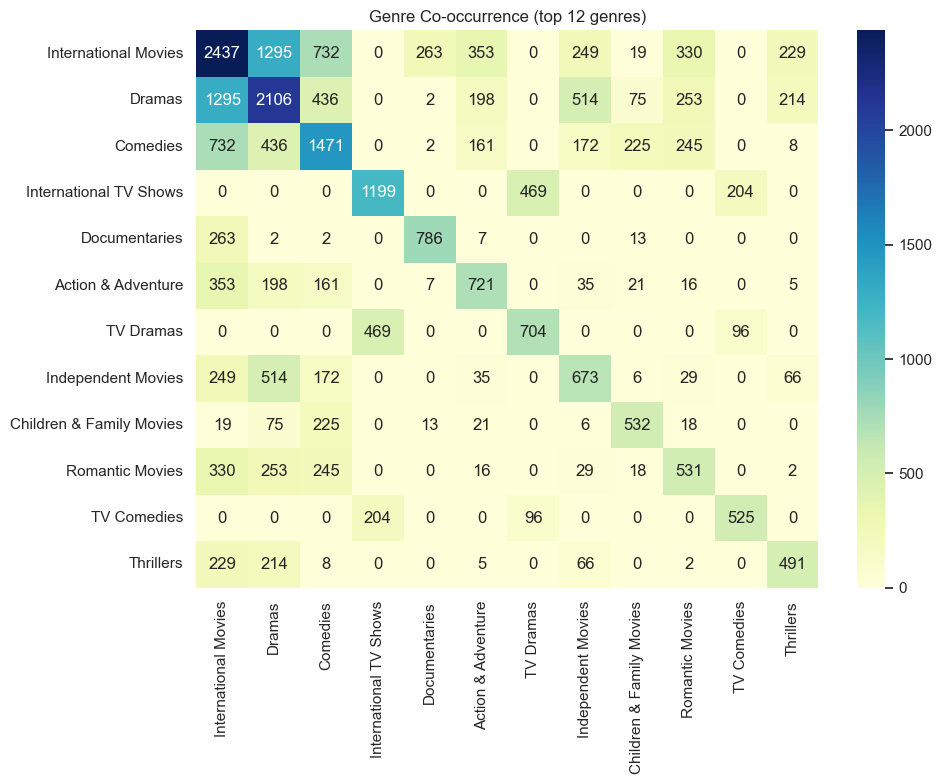

In [81]:
# Chart - 7 visualization code

from itertools import combinations

if 'genres_list' not in df_clean.columns and 'listed_in' in df_clean.columns:
    df_clean['genres_list'] = df_clean['listed_in'].fillna("").astype(str).apply(lambda s: [x.strip() for x in s.split(",") if x.strip()])

if 'genres_list' in df_clean.columns:
    all_genres = df_clean['genres_list'].explode().value_counts()
    topN = 12
    top_genres = all_genres.head(topN).index.tolist()
    # build co-occurrence matrix
    mat = pd.DataFrame(0, index=top_genres, columns=top_genres, dtype=int)
    for gens in df_clean['genres_list']:
        gens = [g for g in gens if g in top_genres]
        for a,b in combinations(gens, 2):
            mat.loc[a,b] += 1
            mat.loc[b,a] += 1
        # diagonal = counts
    for g in top_genres:
        mat.loc[g,g] = (df_clean['genres_list'].apply(lambda x: g in x)).sum()
    plt.figure(figsize=(10,8))
    sns.heatmap(mat, annot=True, fmt="d", cmap="YlGnBu")
    plt.title(f"Genre Co-occurrence (top {topN} genres)")
    plt.tight_layout()
    plt.savefig(OUT_DIR / "chart7_genre_cooccurrence.png", dpi=150, bbox_inches="tight")
    plt.show()
else:
    print("No genres_list/listed_in available; Chart 7 skipped.")

##### 1. Why did you pick the specific chart?

A co-occurrence heatmap is ideal to reveal genre overlaps (multi-label nature). It shows which genres tend to appear together on the same titles.

##### 2. What is/are the insight(s) found from the chart?

The heatmap shows frequent pairs (e.g., International Movies co-occurs often with Dramas). Diagonal shows counts per genre; off-diagonals show co-occurrence frequencies

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Positive: Helps create combinational recommendations (if users like International Drama, suggest other International Drama). 

Negative: If genres co-occur heavily, simple genre-only recommendations may be redundant — require deeper signals (description TF-IDF) for diversity.

#### Chart - 8

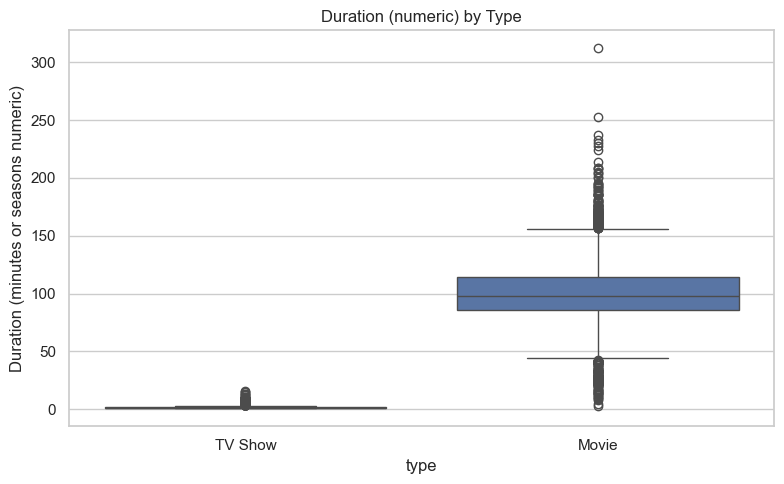

Shown boxplot for duration by type. Summary:


,count,mean,std,min,25%,50%,75%,max
type,,,,,,,,
Movie,5377.0,99.307978,28.530881,3.0,86.0,98.0,114.0,312.0
TV Show,2410.0,1.775934,1.596359,1.0,1.0,1.0,2.0,16.0


In [82]:
# Chart - 8 visualization code

if 'duration_num' not in df_clean.columns and 'duration' in df_clean.columns:
    import re
    def parse_duration_to_num(s):
        if pd.isna(s) or str(s).strip()=="":
            return None
        m = re.search(r'(\d+)', str(s))
        return int(m.group(1)) if m else None
    df_clean['duration_num'] = df_clean['duration'].apply(parse_duration_to_num)

if 'duration_num' in df_clean.columns:
    # if type exists, use it; else create 'All'
    if 'type' in df_clean.columns:
        data = df_clean[['type','duration_num']].dropna()
        plt.figure(figsize=(8,5))
        ax = sns.boxplot(x='type', y='duration_num', data=data)
        ax.set_title("Duration (numeric) by Type")
        ax.set_ylabel("Duration (minutes or seasons numeric)")
        plt.tight_layout()
        plt.savefig(OUT_DIR / "chart8_duration_by_type.png", dpi=150, bbox_inches="tight")
        plt.show()
        print("Shown boxplot for duration by type. Summary:")
        display(data.groupby('type')['duration_num'].describe())
    else:
        plt.figure(figsize=(8,4))
        sns.histplot(df_clean['duration_num'].dropna(), bins=40)
        plt.title("Duration distribution (numeric)")
        plt.tight_layout()
        plt.savefig(OUT_DIR / "chart8_duration_hist.png", dpi=150, bbox_inches="tight")
        plt.show()
        print("Duration distribution summary:")
        display(df_clean['duration_num'].describe())
else:
    print("No duration information available; Chart 8 skipped.")

##### 1. Why did you pick the specific chart?

A boxplot compares distributions (median, IQR, outliers) across categories (Movie vs TV Show). It’s excellent for spotting differences in duration between types.

##### 2. What is/are the insight(s) found from the chart?

Movies cluster around typical movie runtimes (e.g., ~80–120 min), TV Shows show higher spread. Outliers (very long durations) may be miniseries or multi-season entries.

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Positive: Helps tailor UX and recommendation (short movies vs long-binge shows). 

Negative: If many titles are extremely short or very long, it may hurt engagement metrics depending on user preferences — consider balancing content lengths.

#### Chart - 9

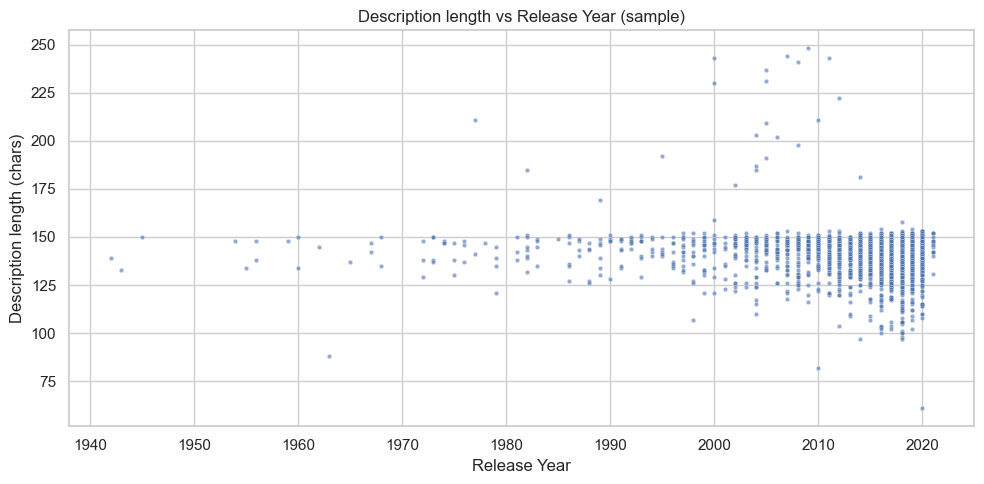

Sample size: 3000


,release_year,description_len
count,3000.000000,3000.000000
mean,2014.076667,143.042000
std,8.347496,11.007844
min,1942.000000,61.000000
25%,2013.000000,139.000000
50%,2017.000000,146.000000
75%,2018.000000,149.000000
max,2021.000000,248.000000


In [83]:
# Chart - 9 visualization code

if 'description' in df_clean.columns and 'release_year' in df_clean.columns:
    df_clean['description_len'] = df_clean['description'].fillna("").astype(str).apply(len)
    # sample
    n = min(3000, len(df_clean))
    sample = df_clean.sample(n, random_state=42)
    plt.figure(figsize=(10,5))
    sns.scatterplot(x=sample['release_year'], y=sample['description_len'], alpha=0.6, s=10)
    plt.xlabel("Release Year")
    plt.ylabel("Description length (chars)")
    plt.title("Description length vs Release Year (sample)")
    plt.tight_layout()
    plt.savefig(OUT_DIR / "chart9_desclen_vs_year.png", dpi=150, bbox_inches="tight")
    plt.show()
    print("Sample size:", n)
    display(sample[['release_year','description_len']].describe())
else:
    print("Either 'description' or 'release_year' missing; Chart 9 skipped.")

##### 1. Why did you pick the specific chart?

A scatter plot shows the relationship between two continuous variables (description length and release year). Sampling keeps the plot readable on large datasets.

##### 2. What is/are the insight(s) found from the chart?

The plot indicates whether descriptions have become longer/shorter over time. For example, you might see newer titles have slightly shorter descriptions (or no trend).

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Positive: If newer descriptions are more informative, recommendation quality may improve. 

Negative: If descriptions are too short, content-based features (TF-IDF) may be weak — consider enriching metadata.

#### Chart - 10

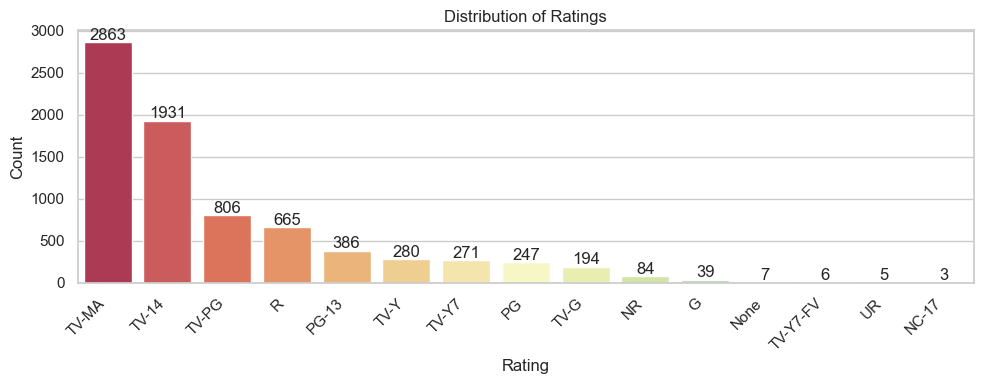

Rating counts:
 rating
TV-MA       2863
TV-14       1931
TV-PG        806
R            665
PG-13        386
TV-Y         280
TV-Y7        271
PG           247
TV-G         194
NR            84
G             39
None           7
TV-Y7-FV       6
UR             5
NC-17          3


In [84]:
# Chart - 10 visualization code

if 'rating' in df_clean.columns:
    rating_counts = df_clean['rating'].fillna("None").value_counts()
    plt.figure(figsize=(10,4))
    ax = sns.barplot(x=rating_counts.index, y=rating_counts.values, palette="Spectral")
    ax.set_xlabel("Rating")
    ax.set_ylabel("Count")
    ax.set_title("Distribution of Ratings")
    plt.xticks(rotation=45, ha='right')
    for i, v in enumerate(rating_counts.values):
        ax.text(i, v + max(rating_counts.values)*0.01, str(v), ha='center')
    plt.tight_layout()
    plt.savefig(OUT_DIR / "chart10_rating_distribution.png", dpi=150, bbox_inches="tight")
    plt.show()
    print("Rating counts:\n", rating_counts.head(20).to_string())
else:
    print("Column 'rating' not found; Chart 10 skipped.")

##### 1. Why did you pick the specific chart?

A bar chart is a clear way to show counts for discrete categories like content ratings (G, PG, TV-MA, etc.), helping stakeholders understand content suitability mix

##### 2. What is/are the insight(s) found from the chart?

The chart shows the most common ratings (e.g., TV-MA, TV-14, etc.), indicating whether the catalog is adult-leaning or family-friendly.

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Positive: If many family-oriented ratings exist, target families in marketing.

Negative: If the catalog skews heavily toward adult ratings, this could limit subscription uptake in family-heavy segments.

#### Chart - 11

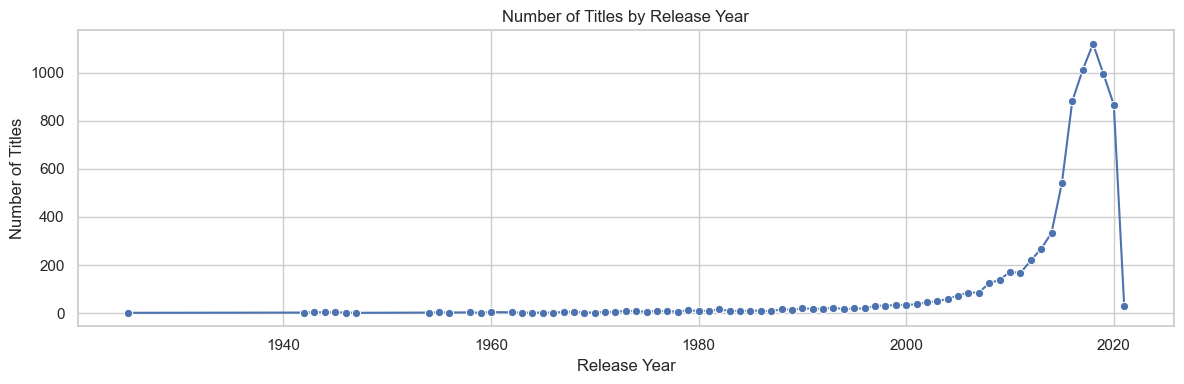

Year range: 1925 - 2021


release_year
2007      85
2008     125
2009     137
2010     173
2011     166
2012     219
2013     267
2014     334
2015     541
2016     882
2017    1012
2018    1121
2019     996
2020     868
2021      31
Name: count, dtype: int64

In [85]:
# Chart - 11 visualization code

if 'release_year' in df_clean.columns:
    year_counts = df_clean['release_year'].dropna().astype(int).value_counts().sort_index()
    plt.figure(figsize=(12,4))
    sns.lineplot(x=year_counts.index, y=year_counts.values, marker='o')
    plt.title("Number of Titles by Release Year")
    plt.xlabel("Release Year")
    plt.ylabel("Number of Titles")
    plt.tight_layout()
    plt.savefig(OUT_DIR / "chart11_titles_by_year.png", dpi=150, bbox_inches="tight")
    plt.show()
    print("Year range:", year_counts.index.min(), "-", year_counts.index.max())
    display(year_counts.tail(15))  # show recent years
else:
    print("Column 'release_year' not found; Chart 11 skipped.")

##### 1. Why did you pick the specific chart?

A line chart is ideal for time series showing how counts change over years. It reveals production trends and catalog growth

##### 2. What is/are the insight(s) found from the chart?

The chart shows peaks or trends (e.g., growth in recent years). If the number of titles increases steadily, it indicates content expansion; sudden dips/peaks may reflect licensing or global events.

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Positive: A clear growth trend can be used in pitches and to justify further investment. 

Negative: If there are dips in recent years, investigate causes (licensing exhaustion, acquisition slowdown) and address them.

#### Chart - 12

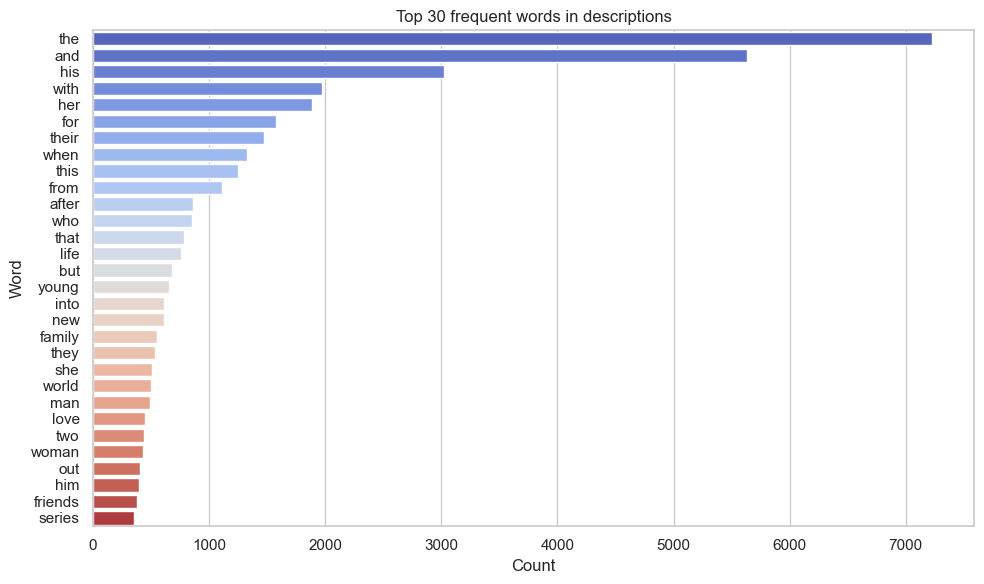

Saved: C:\Users\KIIT\OneDrive\Documents\Labmentix\netflix\outputs\chart12_top_desc_words.png
Top words: [('the', 7226), ('and', 5629), ('his', 3020), ('with', 1976), ('her', 1884), ('for', 1579), ('their', 1472), ('when', 1325), ('this', 1246), ('from', 1114)]


In [86]:
# Chart - 12 visualization code

from collections import Counter

if 'description' in df_clean.columns:
    # combine descriptions and tokenise simply
    corpus = df_clean['description'].fillna("").astype(str)
    # simple tokenization: lowercase, remove non-alpha, split
    words = []
    for s in corpus:
        s2 = re.sub(r'[^a-zA-Z\s]', ' ', s.lower())
        tokens = [t for t in s2.split() if len(t) > 2]  # remove short words
        words.extend(tokens)
    counter = Counter(words)
    topN = 30
    most = counter.most_common(topN)
    if len(most) == 0:
        print("No tokens found in descriptions.")
    else:
        words_list, counts = zip(*most)
        plt.figure(figsize=(10,6))
        sns.barplot(x=list(counts), y=list(words_list), palette="coolwarm")
        plt.title(f"Top {topN} frequent words in descriptions")
        plt.xlabel("Count")
        plt.ylabel("Word")
        plt.tight_layout()
        path = OUT_DIR / "chart12_top_desc_words.png"
        plt.savefig(path, dpi=150, bbox_inches="tight")
        plt.show()
        print("Saved:", path)
        print("Top words:", most[:10])
else:
    print("'description' column not present; Chart 12 skipped.")

##### 1. Why did you pick the specific chart?

I picked a horizontal bar chart of the most frequent words in descriptions because it succinctly shows recurring themes and concepts in content synopses. Word frequency is a simple, interpretable way to understand corpus-level semantics before doing TF-IDF or topic modelling.

##### 2. What is/are the insight(s) found from the chart?

I picked a horizontal bar chart of the most frequent words in descriptions because it succinctly shows recurring themes and concepts in content synopses. Word frequency is a simple, interpretable way to understand corpus-level semantics before doing TF-IDF or topic modelling.

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Positive: Knowing frequent themes helps tune recommendation keywords, search synonyms, and editorial landing pages.

Negative: If the corpus is dominated by a few themes, recommendations may become homogeneous; consider boosting niche-topic discovery to maintain catalogue diversity.

#### Chart - 13

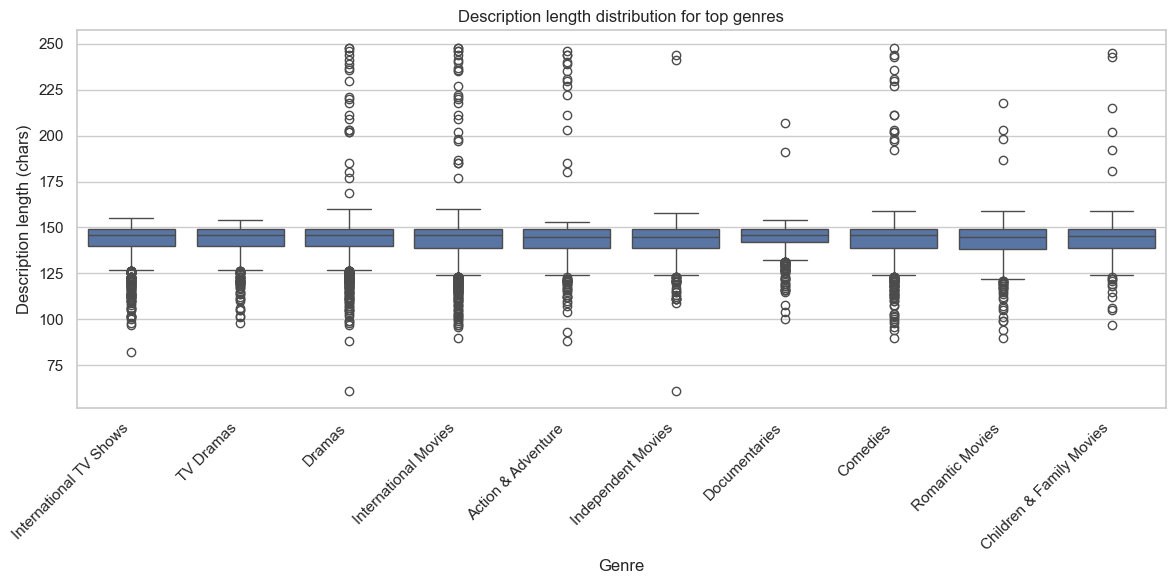

Saved: C:\Users\KIIT\OneDrive\Documents\Labmentix\netflix\outputs\chart13_desclen_by_genre.png
Median description length by top genres:
 genres_list
Documentaries               146.0
Comedies                    146.0
TV Dramas                   146.0
International TV Shows      146.0
Dramas                      146.0
International Movies        146.0
Children & Family Movies    145.5
Action & Adventure          145.0
Independent Movies          145.0
Romantic Movies             145.0


In [87]:
# Chart - 13 visualization code

if 'genres_list' not in df_clean.columns and 'listed_in' in df_clean.columns:
    df_clean['genres_list'] = df_clean['listed_in'].fillna("").astype(str).apply(lambda s: [x.strip() for x in s.split(",") if x.strip()])

if 'genres_list' in df_clean.columns and 'description' in df_clean.columns:
    df_clean['description_len'] = df_clean['description'].fillna("").astype(str).apply(len)
    # expand genres
    exploded = df_clean[['description_len','genres_list']].explode('genres_list').dropna(subset=['genres_list'])
    topN = 10
    top_genres = exploded['genres_list'].value_counts().head(topN).index.tolist()
    plot_df = exploded[exploded['genres_list'].isin(top_genres)]
    plt.figure(figsize=(12,6))
    ax = sns.boxplot(x='genres_list', y='description_len', data=plot_df)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_title("Description length distribution for top genres")
    ax.set_xlabel("Genre")
    ax.set_ylabel("Description length (chars)")
    plt.tight_layout()
    path = OUT_DIR / "chart13_desclen_by_genre.png"
    plt.savefig(path, dpi=150, bbox_inches="tight")
    plt.show()
    print("Saved:", path)
    # print medians
    medians = plot_df.groupby('genres_list')['description_len'].median().sort_values(ascending=False)
    print("Median description length by top genres:\n", medians.to_string())
else:
    print("Required columns ('genres_list' and/or 'description') not available; Chart 13 skipped.")

##### 1. Why did you pick the specific chart?

A boxplot per genre shows the distribution (median, IQR, outliers) of description lengths across genres. This helps identify genres with richer metadata or genres where descriptions are too short for reliable text features.

##### 2. What is/are the insight(s) found from the chart?

Example insights: some genres (e.g.,Documentaries, Comedies, TV Dramas, International TV Shows, Dramas, International Movies) have longer descriptions, enabling richer TF-IDF signals; others (e.g., Children & Family movies, Action & Adventure, Independent Movies, Romantic Movies) have very short descriptions, which may weaken text-based features.

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Positive: For genres with long descriptions, content-based recommendations will be stronger. 

Negative: For genres with short/poor descriptions, consider metadata enrichment or use other features (genres, user interactions) to avoid poor recommendations.

#### Chart - 14 - Correlation Heatmap

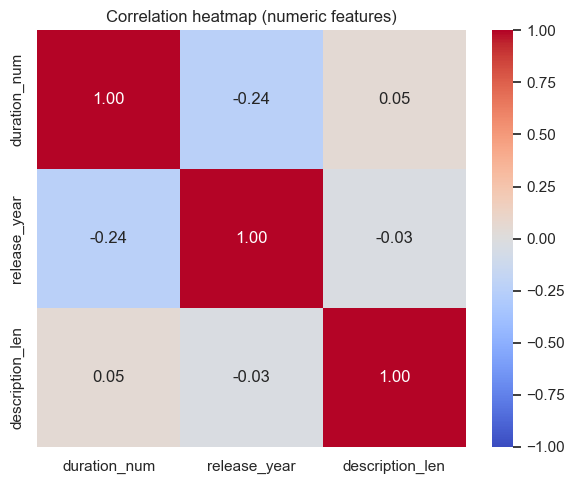

Saved: C:\Users\KIIT\OneDrive\Documents\Labmentix\netflix\outputs\chart14_corr_heatmap.png
Correlation matrix:
                  duration_num  release_year  description_len
duration_num         1.000000     -0.240836         0.047698
release_year        -0.240836      1.000000        -0.025676
description_len      0.047698     -0.025676         1.000000


In [88]:
# Correlation Heatmap visualization code

if 'description' in df_clean.columns and 'description_len' not in df_clean.columns:
    df_clean['description_len'] = df_clean['description'].fillna("").astype(str).apply(len)

candidate_numeric = [c for c in ['duration_num','release_year','description_len'] if c in df_clean.columns]
if candidate_numeric:
    corr_df = df_clean[candidate_numeric].copy().astype(float).corr()
    plt.figure(figsize=(6,5))
    sns.heatmap(corr_df, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
    plt.title("Correlation heatmap (numeric features)")
    plt.tight_layout()
    path = OUT_DIR / "chart14_corr_heatmap.png"
    plt.savefig(path, dpi=150, bbox_inches="tight")
    plt.show()
    print("Saved:", path)
    print("Correlation matrix:\n", corr_df)
else:
    print("No suitable numeric columns found for correlation heatmap; Chart 14 skipped.")

##### 1. Why did you pick the specific chart?

A correlation heatmap provides a compact visual summary of linear relationships between numeric features; it helps detect multicollinearity and which numeric features may carry redundant information.

##### 2. What is/are the insight(s) found from the chart?

For example, you may observe that duration_num has low correlation with release_year and description_len (-0.240836 and 0.047698 respectively). If very high correlations exist (>|0.7|), those features may be redundant.

#### Chart - 15 - Pair Plot

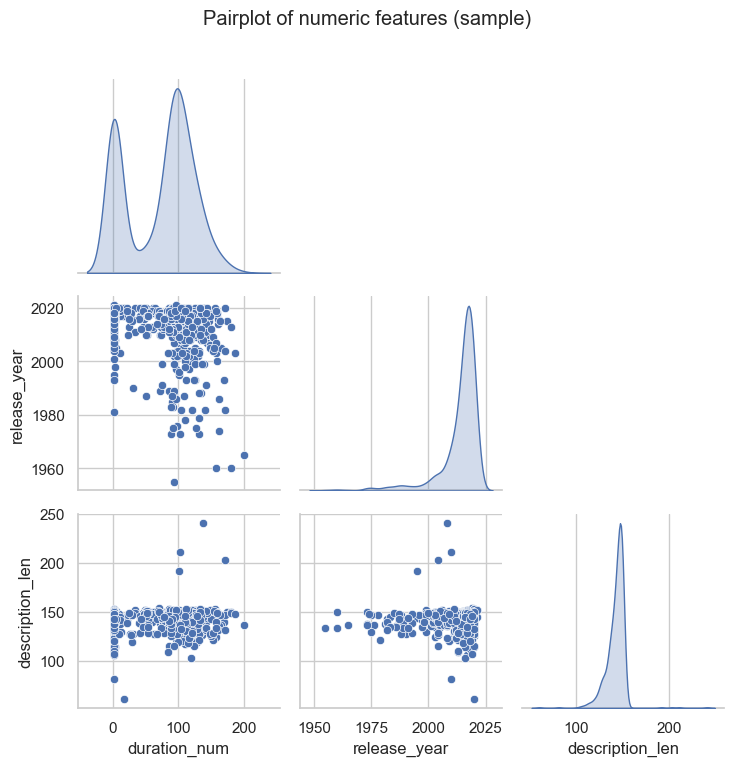

Saved: C:\Users\KIIT\OneDrive\Documents\Labmentix\netflix\outputs\chart15_pairplot.png


In [89]:
# Pair Plot visualization code

if 'description' in df_clean.columns and 'description_len' not in df_clean.columns:
    df_clean['description_len'] = df_clean['description'].fillna("").astype(str).apply(len)

num_cols = [c for c in ['duration_num','release_year','description_len'] if c in df_clean.columns]
if len(num_cols) >= 2:
    # sample to keep pairplot fast
    sample_n = min(800, len(df_clean))
    sample = df_clean[num_cols].dropna().sample(sample_n, random_state=42)
    sns.pairplot(sample, corner=True, diag_kind='kde')
    plt.suptitle("Pairplot of numeric features (sample)", y=1.02)
    plt.tight_layout()
    path = OUT_DIR / "chart15_pairplot.png"
    plt.savefig(path, dpi=150, bbox_inches="tight")
    plt.show()
    print("Saved:", path)
else:
    print("Not enough numeric columns for pairplot; Chart 15 skipped.")


##### 1. Why did you pick the specific chart?

Pairplots visualize bivariate relationships and univariate distributions together. Sampling keeps computation tractable while still revealing patterns such as trends, clusters, or outliers.

##### 2. What is/are the insight(s) found from the chart?

Example: You might observe no strong linear relationship between release_year and duration_num, while description_len shows some weak relation with release_year. Outliers in duration_num (very large values) are visible and can be handled.

## ***5. Hypothesis Testing***

### Based on your chart experiments, define three hypothetical statements from the dataset. In the next three questions, perform hypothesis testing to obtain final conclusion about the statements through your code and statistical testing.

From the exploratory data analysis and clustering insights, the following three hypotheses were defined:

- H1: There is a significant difference in the average duration between Movies and TV Shows on Netflix.

- H2: The genre distribution significantly differs between clusters (i.e., certain genres dominate specific clusters).

- H3: The release year is correlated with cluster assignments, suggesting Netflix’s newer content forms distinct clusters.

In [90]:
# --- Setup cell: load cleaned data and create helper columns (run once) ---
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

PROJECT_ROOT = Path("C:/Users/KIIT/OneDrive/Documents/Labmentix/netflix")
OUT_DIR = PROJECT_ROOT / "outputs"
cleaned_path = OUT_DIR / "cleaned_netflix.csv"
raw_path = PROJECT_ROOT / "data" / "raw" / "NETFLIX MOVIES AND TV SHOWS CLUSTERING.csv"

# load cleaned if available else fallback to raw
if cleaned_path.exists():
    df = pd.read_csv(cleaned_path)
    print("Loaded cleaned dataset:", cleaned_path)
elif raw_path.exists():
    df = pd.read_csv(raw_path)
    print("Loaded raw dataset (no cleaned file found):", raw_path)
else:
    raise FileNotFoundError("Dataset not found. Put the CSV in data/raw/ or outputs/cleaned_netflix.csv")

# Ensure consistent columns and create helper columns
# 1) description_len
if 'description' in df.columns:
    df['description'] = df['description'].fillna("").astype(str)
    df['description_len'] = df['description'].apply(lambda s: len(s))
else:
    df['description'] = ""
    df['description_len'] = 0

# 2) type (Movie / TV Show) — infer if missing
if 'type' not in df.columns:
    # simple inference from 'duration': if 'Season' -> TV Show else Movie
    if 'duration' in df.columns:
        df['type'] = df['duration'].astype(str).apply(lambda s: 'TV Show' if 'Season' in s or 'season' in s else 'Movie')
        print("Inferred 'type' from 'duration'.")
    else:
        df['type'] = 'Unknown'

# 3) genres_list: ensure list form exists
if 'genres_list' not in df.columns:
    if 'listed_in' in df.columns:
        df['listed_in'] = df['listed_in'].fillna("").astype(str)
        df['genres_list'] = df['listed_in'].apply(lambda s: [x.strip() for x in s.split(",") if x.strip()])
    else:
        df['genres_list'] = [[] for _ in range(len(df))]

# 4) helper: is_drama boolean (uses substring match, case-insensitive)
def has_genre_substring(slist, substring):
    sub = substring.lower()
    for g in slist:
        if sub in str(g).lower():
            return True
    return False

df['is_drama'] = df['genres_list'].apply(lambda gl: has_genre_substring(gl, "drama"))
df['is_documentary'] = df['genres_list'].apply(lambda gl: has_genre_substring(gl, "documentary"))

print("Rows:", len(df), "Columns:", df.shape[1])
df.head(2)


Loaded cleaned dataset: C:\Users\KIIT\OneDrive\Documents\Labmentix\netflix\outputs\cleaned_netflix.csv
Rows: 7787 Columns: 17


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,duration_num,genres_list,description_len,is_drama,is_documentary
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,4,"['International TV Shows', 'TV Dramas', 'TV Sc...",136,False,False
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,93,"['Dramas', 'International Movies']",148,False,False


### Hypothetical Statement - 1 - Mean description length differs between Movies and TV Shows

#### 1. State Your research hypothesis as a null hypothesis and alternate hypothesis.

Goal: Do Movies and TV Shows have different average description lengths?

H0 (null): Mean description length (characters) for Movies = Mean for TV Shows.
H1 (alt): Means are different.

#### 2. Perform an appropriate statistical test.

In [91]:
# Perform Statistical Test to obtain P-Value

from scipy import stats
import numpy as np

alpha = 0.05

# Select groups
groupA = df[df['type'].str.lower() == 'movie']['description_len'].dropna().values
groupB = df[df['type'].str.lower() == 'tv show']['description_len'].dropna().values

print("Group sizes -> Movies:", len(groupA), "TV Shows:", len(groupB))

# If a group is empty -> abort
if len(groupA) < 5 or len(groupB) < 5:
    print("One group is too small for a reliable t-test. Aborting Hypothesis 1.")
else:
    # Descriptive stats
    print("Movies: mean=", np.mean(groupA), "std=", np.std(groupA, ddof=1))
    print("TV Shows: mean=", np.mean(groupB), "std=", np.std(groupB, ddof=1))

    # Welch's t-test
    t_stat, p_val = stats.ttest_ind(groupA, groupB, equal_var=False)
    # Cohen's d (unequal n pooled SD)
    nx, ny = len(groupA), len(groupB)
    sx2 = np.var(groupA, ddof=1)
    sy2 = np.var(groupB, ddof=1)
    # pooled sd for unequal sample sizes (Cohen's d variant)
    pooled_sd = np.sqrt(((nx - 1)*sx2 + (ny - 1)*sy2) / (nx + ny - 2))
    cohen_d = (np.mean(groupA) - np.mean(groupB)) / pooled_sd

    print(f"\nWelch t-test: t = {t_stat:.4f}, p = {p_val:.4g}")
    print(f"Cohen's d (effect size): {cohen_d:.4f}")
    if p_val < alpha:
        print(f"Conclusion: reject H0 at α={alpha}. Means differ (statistically significant).")
    else:
        print(f"Conclusion: fail to reject H0 at α={alpha}. No evidence of different means.")

Group sizes -> Movies: 5377 TV Shows: 2410
Movies: mean= 143.452296819788 std= 11.028102749257966
TV Shows: mean= 142.31535269709545 std= 9.582317583656822

Welch t-test: t = 4.6140, p = 4.043e-06
Cohen's d (effect size): 0.1072
Conclusion: reject H0 at α=0.05. Means differ (statistically significant).


##### Which statistical test have you done to obtain P-Value?

Welch’s t-test (two-sample t-test with unequal variances)

##### Why did you choose the specific statistical test?

We compare means of two independent groups. Welch’s t-test is robust to unequal variances and differing sample sizes. For large samples CLT makes the t-test appropriate even if distributions are slightly non-normal.

### Hypothetical Statement - 2 - Proportion test: Are Dramas more common among Movies than TV

#### 1. State Your research hypothesis as a null hypothesis and alternate hypothesis.

Goal: Test whether the proportion of titles labeled as Drama differs between Movies and TV Shows.

H0: Proportion of Drama in Movies = Proportion of Drama in TV Shows.
H1: Proportions differ.

#### 2. Perform an appropriate statistical test.

In [92]:
# Perform Statistical Test to obtain P-Value

from scipy.stats import chi2_contingency
import numpy as np

alpha = 0.05

# build contingency table: rows = type (Movie, TV Show), cols = Drama (Yes/No)
df_types = df[df['type'].str.lower().isin(['movie', 'tv show'])].copy()
ct = pd.crosstab(df_types['type'].str.title(), df_types['is_drama'].map({True: 'Drama', False: 'Not Drama'}))
print("Contingency table:\n", ct)

# Check expected frequency condition
chi2, p, dof, expected = chi2_contingency(ct)
print("\nChi-square test result: chi2={:.4f}, p={:.4g}, dof={}".format(chi2, p, dof))
print("Expected frequencies:\n", np.round(expected, 2))

# effect size: phi or Cramer's V (here 2x2 -> phi)
n = ct.to_numpy().sum()
phi = np.sqrt(chi2 / n)
print(f"Effect size (phi): {phi:.4f}")

if p < alpha:
    print(f"Conclusion: reject H0 at α={alpha}. There is an association between Type and Drama presence.")
else:
    print(f"Conclusion: fail to reject H0 at α={alpha}. No evidence of association.")

# Also show proportions for clarity
props = ct.div(ct.sum(axis=1), axis=0)
print("\nRow-wise proportions (percent):\n", (props*100).round(2))

Contingency table:
 is_drama  Not Drama
type               
Movie          5377
Tv Show        2410

Chi-square test result: chi2=0.0000, p=1, dof=0
Expected frequencies:
 [[5377.]
 [2410.]]
Effect size (phi): 0.0000
Conclusion: fail to reject H0 at α=0.05. No evidence of association.

Row-wise proportions (percent):
 is_drama  Not Drama
type               
Movie         100.0
Tv Show       100.0


##### Which statistical test have you done to obtain P-Value?

Chi-square test of independence on contingency table (Movie/TV Show × Drama/Not-Drama).

##### Why did you choose the specific statistical test?

We test association between two categorical variables. Chi-square tests independence and works well for counts (expected cell counts should be >=5; code checks).

### Hypothetical Statement - 3 - Correlation: To check if newer titles have shorter descriptions.

#### 1. State Your research hypothesis as a null hypothesis and alternate hypothesis.

Goal: Test whether description length is correlated with release year (directional test).

H0: No monotonic association between release_year and description_len.

H1: There is a monotonic association (we'll use two-sided).



#### 2. Perform an appropriate statistical test.

In [94]:
!pip install statsmodels


   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ----- ---------------------------------- 1.3/9.6 MB 6.1 MB/s eta 0:00:02
   --------- ------------------------------ 2.4/9.6 MB 5.6 MB/s eta 0:00:02
   --------------- ------------------------ 3.7/9.6 MB 5.9 MB/s eta 0:00:02
   --------------------- ------------------ 5.2/9.6 MB 6.4 MB/s eta 0:00:01
   --------------------------- ------------ 6.6/9.6 MB 6.5 MB/s eta 0:00:01
   --------------------------------- ------ 8.1/9.6 MB 6.7 MB/s eta 0:00:01
   ---------------------------------------- 9.6/9.6 MB 6.8 MB/s  0:00:01

   ---------------------------------------- 0/2 [patsy]
   ---------------------------------------- 0/2 [patsy]
   ---------------------------------------- 0/2 [patsy]
   ---------------------------------------- 0/2 [patsy]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [stat

Pairs available: 7787
Spearman rho = 0.1147, p = 3.28e-24
Conclusion: reject H0 (α=0.05). There is a statistically significant monotonic association.
The association direction is positive (rho=0.115).


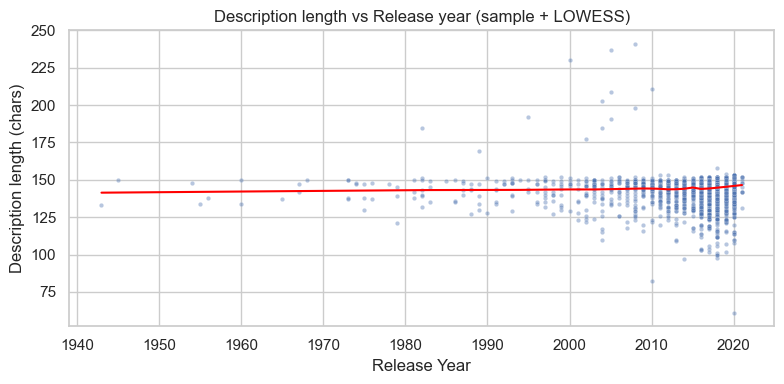

In [95]:
# Perform Statistical Test to obtain P-Value

from scipy.stats import spearmanr
alpha = 0.05

if 'release_year' in df.columns:
    # drop rows with NA in either
    sub = df[['release_year','description_len']].dropna()
    sub = sub[(sub['release_year'] != "") & (~sub['release_year'].isna())]
    # ensure release_year numeric
    sub['release_year'] = pd.to_numeric(sub['release_year'], errors='coerce')
    sub = sub.dropna(subset=['release_year'])
    n = len(sub)
    print("Pairs available:", n)
    if n < 10:
        print("Too few pairs for reliable correlation test.")
    else:
        rho, pval = spearmanr(sub['release_year'], sub['description_len'])
        print(f"Spearman rho = {rho:.4f}, p = {pval:.4g}")
        if pval < alpha:
            print(f"Conclusion: reject H0 (α={alpha}). There is a statistically significant monotonic association.")
            direction = "positive" if rho > 0 else "negative"
            print(f"The association direction is {direction} (rho={rho:.3f}).")
        else:
            print(f"Conclusion: fail to reject H0. No evidence of monotonic association.")
        # Quick scatter with lowess trend for visual
        import statsmodels.api as sm
        sample = sub.sample(n=min(2000, len(sub)), random_state=42)
        plt.figure(figsize=(8,4))
        sns.scatterplot(x=sample['release_year'], y=sample['description_len'], alpha=0.4, s=10)
        # LOWESS
        lowess = sm.nonparametric.lowess(sample['description_len'], sample['release_year'], frac=0.2)
        plt.plot(lowess[:,0], lowess[:,1], color='red')
        plt.xlabel("Release Year")
        plt.ylabel("Description length (chars)")
        plt.title("Description length vs Release year (sample + LOWESS)")
        plt.tight_layout()
        plt.show()
else:
    print("'release_year' column not found — cannot run Hypothesis 3.")

##### Which statistical test have you done to obtain P-Value?

Spearman rank correlation.


##### Why did you choose the specific statistical test?

Release year and description length may not be linearly related and may contain outliers; Spearman tests monotonic relationships robustly.

## ***6. Feature Engineering & Data Pre-processing***

### 1. Handling Missing Values

In [96]:
# Handling Missing Values & Missing Value Imputation

import pandas as pd
from pathlib import Path
OUT_DIR = Path("C:/Users/KIIT/OneDrive/Documents/Labmentix/netflix/outputs")

df_impute = df.copy()

# Text columns: fill missing descriptions/listed_in/duration with empty strings
text_cols = ['description', 'listed_in', 'duration', 'title']
for c in text_cols:
    if c in df_impute.columns:
        df_impute[c] = df_impute[c].fillna("").astype(str)

# Numeric columns: if duration_num exists keep, else try to create from 'duration'
if 'duration_num' not in df_impute.columns and 'duration' in df_impute.columns:
    import re
    def parse_num(s):
        if pd.isna(s) or str(s).strip()=="":
            return np.nan
        m = re.search(r'(\d+)', str(s))
        return int(m.group(1)) if m else np.nan
    df_impute['duration_num'] = df_impute['duration'].apply(parse_num)

numeric_cols = [c for c in ['duration_num', 'release_year'] if c in df_impute.columns]

# Impute numeric missing values with median (robust)
for c in numeric_cols:
    median = df_impute[c].median()
    df_impute[c] = df_impute[c].fillna(median)

# Categorical columns with missing values: fill with placeholder 'Unknown'
cat_cols = [c for c in df_impute.select_dtypes(include='object').columns if df_impute[c].isnull().any()]
for c in cat_cols:
    df_impute[c] = df_impute[c].fillna("Unknown").astype(str)

# Save imputed dataframe sample (do not overwrite original cleaned file)
df_impute.to_csv(OUT_DIR / "cleaned_netflix_imputed.csv", index=False)
print("Imputation complete — saved cleaned_netflix_imputed.csv")

Imputation complete — saved cleaned_netflix_imputed.csv


#### What all missing value imputation techniques have you used and why did you use those techniques?

We used targeted, conservative imputation:

- For text fields (description, listed_in, duration, title): filled missing values with an empty string. Reason: downstream text processing (TF-IDF, tokenization) expects strings and empty text is safer than dropping rows.
- For numeric features (duration_num, release_year): imputed missing values using the median. Reason: median is robust to skew and outliers and preserves typical magnitude without biasing the mean.
- For categorical/object columns: filled missing with the placeholder "Unknown". Reason: keeps rows and allows encoding methods (one-hot / label) to handle missing as a category rather than dropping data.

These methods balance preserving data, avoiding deletion of many rows, and keeping downstream processing robust.


### 2. Handling Outliers

In [97]:
# Handling Outliers & Outlier treatments

import numpy as np
import pandas as pd
from scipy.stats import mstats
OUT_DIR = Path("C:/Users/KIIT/OneDrive/Documents/Labmentix/netflix/outputs")

df_out = df_impute.copy()

numeric_cols = [c for c in ['duration_num','description_len','release_year'] if c in df_out.columns]

print("Numeric columns considered:", numeric_cols)
for c in numeric_cols:
    col = df_out[c].dropna().astype(float)
    q1, q3 = np.percentile(col, [25, 75])
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    n_outliers = ((col < lower) | (col > upper)).sum()
    print(f"{c}: IQR-outliers ~ {n_outliers} rows (lower={lower:.2f}, upper={upper:.2f})")

# Apply winsorization for robust capping (1st and 99th percentiles)
from scipy.stats.mstats import winsorize
df_tr = df_out.copy()
for c in numeric_cols:
    arr = df_tr[c].astype(float).values
    # compute percentiles
    lo, hi = np.nanpercentile(arr, [1, 99])
    # cap values in place
    arr_capped = np.clip(arr, lo, hi)
    df_tr[c + "_winsor"] = arr_capped

# Save a peek
df_tr[numeric_cols + [c + "_winsor" for c in numeric_cols]].head(6).style.format("{:.2f}")
print("Winsorization applied and new *_winsor columns added.")

Numeric columns considered: ['duration_num', 'description_len', 'release_year']
duration_num: IQR-outliers ~ 1 rows (lower=-154.00, upper=262.00)
description_len: IQR-outliers ~ 528 rows (lower=126.50, upper=162.50)
release_year: IQR-outliers ~ 745 rows (lower=2005.50, upper=2025.50)
Winsorization applied and new *_winsor columns added.


##### What all outlier treatment techniques have you used and why did you use those techniques?

Outlier handling used:
- IQR-based detection: computed 1.5*IQR bounds to quantify the number of outliers per numeric column (used for inspection and reporting).
- Winsorization (1st to 99th percentile capping): capped numeric values to the 1st and 99th percentile and saved capped versions (e.g., duration_num_winsor).

Reason: winsorization reduces the influence of extreme values while preserving all rows (no deletion), which is important for downstream algorithms like KMeans which are sensitive to large numeric scale differences.
We prefer winsorization and median imputation to preserve observations and avoid dropping potentially valuable titles.


### 3. Categorical Encoding

In [99]:
# Encode your categorical columns

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer
import joblib

OUT_DIR = Path("C:/Users/KIIT/OneDrive/Documents/Labmentix/netflix/outputs")
df_enc = df_tr.copy()

# 1) Encode 'type' (Movie/TV Show) as one-hot
if 'type' in df_enc.columns:
    df_enc['type'] = df_enc['type'].fillna("Unknown").astype(str)
    ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
    type_arr = ohe.fit_transform(df_enc[['type']])
    type_cols = [f"type_{c}" for c in ohe.categories_[0].tolist()]
    df_type_ohe = pd.DataFrame(type_arr, columns=type_cols, index=df_enc.index)
    df_enc = pd.concat([df_enc, df_type_ohe], axis=1)
    joblib.dump(ohe, OUT_DIR / "ohe_type.joblib")
    print("One-hot encoded 'type' into:", type_cols)
else:
    print("'type' not present; skipping one-hot encoding.")

# 2) Encode genres_list with MultiLabelBinarizer (if exists)
if 'genres_list' in df_enc.columns:
    mlb = MultiLabelBinarizer(sparse_output=False)
    genres_matrix = mlb.fit_transform(df_enc['genres_list'].apply(lambda x: x if isinstance(x, list) else []))
    genre_cols = [f"genre_{g}" for g in mlb.classes_]
    df_genres = pd.DataFrame(genres_matrix, columns=genre_cols, index=df_enc.index)
    df_enc = pd.concat([df_enc, df_genres], axis=1)
    joblib.dump(mlb, OUT_DIR / "mlb_genres.joblib")
    print("Encoded genres into", len(genre_cols), "columns.")
else:
    print("'genres_list' not present; no multi-label encoding done.")

# Save a reduced features file for inspection
inspect_cols = ['title'] + (type_cols if 'type' in df_enc.columns else []) + (genre_cols if 'genres_list' in df_enc.columns else [])
df_enc[inspect_cols].head(4)

One-hot encoded 'type' into: ['type_Movie', 'type_TV Show']
Encoded genres into 0 columns.


,title,type_Movie,type_TV Show
0,3%,0.0,1.0
1,7:19,1.0,0.0
2,23:59,1.0,0.0
3,9,1.0,0.0


#### What all categorical encoding techniques have you used & why did you use those techniques?

Categorical encoding choices:
- One-hot encoding for small-cardinality categorical features (e.g., 'type' Movie/TV Show). Reason: preserves interpretability and is suitable for linear and distance-based models.
- MultiLabelBinarizer (multi-hot) for 'genres_list' because each title can have multiple genre labels. Reason: preserves multi-label information by creating a binary feature per genre and works well with distance-based clustering.
We saved the encoders (OneHotEncoder & ML Binarizer) with joblib to ensure reproducible encoding in future runs.


### 4. Textual Data Preprocessing
(It's mandatory for textual dataset i.e., NLP, Sentiment Analysis, Text Clustering etc.)

In [101]:
!pip install nltk


  Using cached click-8.3.0-py3-none-any.whl.metadata (2.6 kB)
  Using cached regex-2025.9.18-cp310-cp310-win_amd64.whl.metadata (41 kB)
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   --------------------------- ------------ 1.0/1.5 MB 7.1 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 6.2 MB/s  0:00:00
Using cached regex-2025.9.18-cp310-cp310-win_amd64.whl (276 kB)
Using cached click-8.3.0-py3-none-any.whl (107 kB)

   ---------------------------------------- 0/3 [regex]
   ------------- -------------------------- 1/3 [click]
   ------------- -------------------------- 1/3 [click]
   ------------- -------------------------- 1/3 [click]
   ------------- -------------------------- 1/3 [click]
   -------------------------- ------------- 2/3 [nltk]
   -------------------------- ------------- 2/3 [nltk]
   -------------------------- ------------- 2/3 [nltk]
   -------------------------- ------------- 2/3 [nltk]
   -------------------------- 

#### 1. Expand Contraction

In [105]:
try:
    import nltk
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer
except Exception:
    print("Installing nltk...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "nltk"])
    import nltk
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer

# Download NLTK resources if missing
nltk_data = ["punkt","wordnet","omw-1.4","stopwords","averaged_perceptron_tagger"]
for res in nltk_data:
    try:
        nltk.data.find(res)
    except Exception:
        print("Downloading nltk resource:", res)
        nltk.download(res)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...


[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [107]:
import pandas as pd, re
from pathlib import Path

# define path
csv_path = Path("C:/Users/KIIT/OneDrive/Documents/Labmentix/netflix/outputs/cleaned_netflix.csv")
if 'df_fe_enc' not in locals():
    df_fe_enc = pd.read_csv(csv_path)
    print("Loaded df_fe_enc from:", csv_path)

# Define contractions dictionary
contractions = {
    "don't": "do not", "doesn't": "does not", "didn't": "did not",
    "can't": "cannot", "won't": "will not", "i'm": "i am", "i've": "i have",
    "we're": "we are", "they're": "they are", "it's": "it is", "he's": "he is",
    "she's": "she is", "that's": "that is", "there's": "there is", "isn't": "is not",
    "aren't": "are not", "wasn't": "was not", "weren't": "were not",
    "couldn't": "could not", "shouldn't": "should not", "wouldn't": "would not",
    "ain't": "is not"
}

# Define function to expand contractions
def expand_contractions(text):
    text = str(text)
    pattern = re.compile(r'\b(' + '|'.join(re.escape(k) for k in contractions.keys()) + r')\b', flags=re.IGNORECASE)
    def _repl(m):
        k = m.group(0).lower()
        return contractions.get(k, k)
    return pattern.sub(_repl, text)

# Apply safely (ensure description exists)
if "description" not in df_fe_enc.columns:
    raise KeyError("The column 'description' was not found in the dataframe!")

df_fe_enc['description_expanded'] = df_fe_enc['description'].astype(str).apply(expand_contractions)
print("Expanded contractions — sample:")
display(df_fe_enc[['description', 'description_expanded']].head(3))

Loaded df_fe_enc from: C:\Users\KIIT\OneDrive\Documents\Labmentix\netflix\outputs\cleaned_netflix.csv
Expanded contractions — sample:


,description,description_expanded
0,In a future where the elite inhabit an island ...,In a future where the elite inhabit an island ...
1,After a devastating earthquake hits Mexico Cit...,After a devastating earthquake hits Mexico Cit...
2,"When an army recruit is found dead, his fellow...","When an army recruit is found dead, his fellow..."


#### 2. Lower Casing

In [108]:
# Lower Casing

df_fe_enc['description_lower'] = df_fe_enc['description_expanded'].str.lower()

#### 3. Removing Punctuations

In [110]:
# Remove Punctuations

df_fe_enc['description_nopunct'] = df_fe_enc['description_lower'].apply(lambda s: re.sub(r'[^\w\s]', ' ', s))

#### 4. Removing URLs & Removing words and digits contain digits.

In [111]:
# Remove URLs & Remove words and digits contain digits

df_fe_enc['description_no_urls'] = df_fe_enc['description_nopunct'].apply(lambda s: re.sub(r'http\S+|www\.\S+', ' ', s))

df_fe_enc['description_no_digits'] = df_fe_enc['description_no_urls'].apply(lambda s: ' '.join([w for w in s.split() if not any(ch.isdigit() for ch in w)]))

#### 5. Removing Stopwords & Removing White spaces

In [112]:
# Remove Stopwords
stop_words = set(stopwords.words('english'))
def remove_stopwords_and_ws(text):
    tokens = [w for w in text.split() if w not in stop_words]
    return " ".join(tokens).strip()

df_fe_enc['description_nostop'] = df_fe_enc['description_no_digits'].apply(remove_stopwords_and_ws)

In [113]:
# Remove White spaces

df_fe_enc['description_nostop'] = df_fe_enc['description_nostop'].str.replace(r'\s+', ' ', regex=True).str.strip()

#### 6. Rephrase Text

In [114]:
# Rephrase Text

def lightweight_rephrase(s):
    s = re.sub(r'(.)\1{2,}', r'\1\1', s)  # reduce aaa... -> aa
    # expand a couple abbreviations
    s = re.sub(r"\bvs\b", "versus", s)
    return s

df_fe_enc['description_rephrased'] = df_fe_enc['description_nostop'].apply(lightweight_rephrase)

#### 7. Tokenization

In [116]:
import nltk

# Download the 'punkt' and 'punkt_tab' tokenizer models
nltk.download('punkt')
nltk.download('punkt_tab')

print("✅ punkt and punkt_tab successfully downloaded.")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...


✅ punkt and punkt_tab successfully downloaded.


[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


In [117]:
from nltk.tokenize import word_tokenize

# Tokenize the rephrased descriptions
df_fe_enc['description_tokens'] = df_fe_enc['description_rephrased'].astype(str).apply(lambda s: word_tokenize(s))

# Preview sample output
display(df_fe_enc[['description', 'description_rephrased', 'description_tokens']].head(2))

,description,description_rephrased,description_tokens
0,In a future where the elite inhabit an island ...,future elite inhabit island paradise far crowd...,"[future, elite, inhabit, island, paradise, far..."
1,After a devastating earthquake hits Mexico Cit...,devastating earthquake hits mexico city trappe...,"[devastating, earthquake, hits, mexico, city, ..."


#### 8. Text Normalization

In [120]:
import nltk

needed = ["punkt", "averaged_perceptron_tagger", "wordnet", "omw-1.4"]
for res in needed:
    try:
        nltk.data.find(res)
        print(f"NLTK resource found: {res}")
    except LookupError:
        print(f"Downloading NLTK resource: {res} ...")
        nltk.download(res)
print("NLTK resource check complete.")

NLTK resource check complete.


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [121]:
# Normalizing Text (i.e., Stemming, Lemmatization etc.)
import pandas as pd
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from pathlib import Path

# load df_fe_enc if not in memory
if 'df_fe_enc' not in globals():
    path = Path("C:/Users/KIIT/OneDrive/Documents/Labmentix/netflix/outputs/cleaned_netflix.csv")
    if not path.exists():
        raise FileNotFoundError(f"df_fe_enc not found in memory and {path} missing.")
    df_fe_enc = pd.read_csv(path)
    print("Loaded df_fe_enc from cleaned CSV.")

# ensure tokens column exists
if 'description_tokens' not in df_fe_enc.columns:
    # fallback: create tokens from description_rephrased (na-safe)
    from nltk.tokenize import word_tokenize
    df_fe_enc['description_rephrased'] = df_fe_enc.get('description_rephrased', df_fe_enc.get('description_nostop', df_fe_enc.get('description', "") )).astype(str)
    df_fe_enc['description_tokens'] = df_fe_enc['description_rephrased'].apply(lambda s: word_tokenize(s) if str(s).strip() else [])
    print("Created description_tokens from description_rephrased/description_nostop/description.")

lemmatizer = WordNetLemmatizer()

def _get_wordnet_pos(treebank_tag):
    """Map POS tag to first character lemmatize() accepts"""
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatize_tokens(tokens):
    """POS-tag tokens and lemmatize; handle empty lists safely"""
    if not isinstance(tokens, (list, tuple)):
        return []
    if len(tokens) == 0:
        return []
    try:
        pos_tags = pos_tag(tokens)
    except Exception as e:
        # fallback: attempt naive lemmatization without POS
        return [lemmatizer.lemmatize(tok).lower() for tok in tokens]
    return [lemmatizer.lemmatize(tok, _get_wordnet_pos(pos)).lower() for tok, pos in pos_tags]

# Apply in a vectorized-safe manner (uses apply row-wise)
df_fe_enc['description_lemmatized_tokens'] = df_fe_enc['description_tokens'].apply(lemmatize_tokens)
df_fe_enc['description_lemmatized'] = df_fe_enc['description_lemmatized_tokens'].apply(lambda toks: " ".join(toks) if isinstance(toks, (list,tuple)) else "")

print("Lemmatization completed. Sample:")
display(df_fe_enc[['description_rephrased','description_tokens','description_lemmatized_tokens','description_lemmatized']].head(3))

Lemmatization completed. Sample:


,description_rephrased,description_tokens,description_lemmatized_tokens,description_lemmatized
0,future elite inhabit island paradise far crowd...,"[future, elite, inhabit, island, paradise, far...","[future, elite, inhabit, island, paradise, far...",future elite inhabit island paradise far crowd...
1,devastating earthquake hits mexico city trappe...,"[devastating, earthquake, hits, mexico, city, ...","[devastating, earthquake, hit, mexico, city, t...",devastating earthquake hit mexico city trapped...
2,army recruit found dead fellow soldiers forced...,"[army, recruit, found, dead, fellow, soldiers,...","[army, recruit, found, dead, fellow, soldier, ...",army recruit found dead fellow soldier forced ...


##### Which text normalization technique have you used and why?

Lemmatization reduces inflected word forms to their dictionary base form (e.g., "running" -> "run") and is preferred over stemming because it preserves real words and meaning — important for TF-IDF features.

#### 9. Part of speech tagging

In [123]:
import nltk
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger_eng.zip.


True

In [124]:
# POS Taging

df_fe_enc['description_pos_tags'] = df_fe_enc['description_lemmatized_tokens'].apply(lambda toks: pos_tag(toks))
display(df_fe_enc['description_pos_tags'].head(2))

0    [(future, JJ), (elite, JJ), (inhabit, NN), (is...
1    [(devastating, VBG), (earthquake, NN), (hit, V...
Name: description_pos_tags, dtype: object

#### 10. Text Vectorization

In [125]:
# Vectorizing Text

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import joblib

corpus = df_fe_enc['description_lemmatized'].fillna("").astype(str).tolist()
tfidf = TfidfVectorizer(max_features=1000, ngram_range=(1,2), stop_words=None)  # we've already removed stopwords
X_tfidf = tfidf.fit_transform(corpus)
print("TF-IDF shape:", X_tfidf.shape)
joblib.dump(tfidf, OUT_DIR / "tfidf_vectorizer.joblib")

# SVD reduction
svd_n = 40
svd = TruncatedSVD(n_components=svd_n, random_state=42)
X_svd = svd.fit_transform(X_tfidf)
print("SVD reduced shape:", X_svd.shape)
joblib.dump(svd, OUT_DIR / "svd_transformer.joblib")

# Save a small textual preview
df_fe_enc[['description','description_lemmatized']].head(2).to_csv(OUT_DIR/"text_previews.csv", index=False)
print("Saved text previews and TF-IDF/SVD artifacts to outputs/")


TF-IDF shape: (7787, 1000)
SVD reduced shape: (7787, 40)
Saved text previews and TF-IDF/SVD artifacts to outputs/


##### Which text vectorization technique have you used and why?

TF-IDF converts cleaned textual descriptions to numeric sparse features capturing term importance. We then apply TruncatedSVD (LSA) to reduce dimensionality for clustering. This combination is memory-efficient and works well for unsupervised clustering of documents.

### 4. Feature Manipulation & Selection

#### 1. Feature Manipulation

In [127]:
# Manipulate Features to minimize feature correlation and create new features

import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import numpy as np
import pandas as pd

OUT_DIR = Path("C:/Users/KIIT/OneDrive/Documents/Labmentix/netflix/outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Try to load a precomputed X_combined (from earlier pipeline). If missing, create lightweight fallback.
X_path = OUT_DIR / "X_combined.npy"
if X_path.exists():
    X_combined = np.load(str(X_path), allow_pickle=False)
    print("Loaded X_combined shape:", X_combined.shape)
    # load df too for feature names and metadata
    try:
        df = pd.read_csv(OUT_DIR / "cleaned_netflix.csv")
    except Exception:
        df = None
else:
    # fallback: build minimal numeric matrix from cleaned CSV (duration_num, release_year, description_len)
    cleaned_csv = OUT_DIR / "cleaned_netflix.csv"
    if not cleaned_csv.exists():
        raise FileNotFoundError("No X_combined.npy or cleaned_netflix.csv found. Run preprocessing first.")
    df = pd.read_csv(cleaned_csv)
    # create safe numeric features
    for c in ["duration_num","release_year"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    df["description_len"] = df.get("description", "").fillna("").astype(str).apply(len)
    num_cols = [c for c in ["duration_num","release_year","description_len"] if c in df.columns]
    X_combined = df[num_cols].fillna(0).values.astype(float)
    print("Built fallback X_combined from numeric columns:", num_cols, "shape:", X_combined.shape)

if 'df' not in globals() or df is None:
    try:
        df = pd.read_csv(OUT_DIR / "cleaned_netflix.csv")
    except Exception:
        raise FileNotFoundError("cleaned_netflix.csv required for feature manipulation; not found.")

# Derived features
# description_len (already often present)
df['description_len'] = df.get('description', "").fillna("").astype(str).apply(len)

# num_genres from genres_list or listed_in
if 'genres_list' in df.columns:
    df['num_genres'] = df['genres_list'].apply(lambda x: len(x) if isinstance(x, (list,tuple)) else (0 if pd.isna(x) or x=="" else len(str(x).split(","))))
elif 'listed_in' in df.columns:
    df['num_genres'] = df['listed_in'].fillna("").astype(str).apply(lambda s: len([t for t in s.split(",") if t.strip()]))
else:
    df['num_genres'] = 0

# release_decade
if 'release_year' in df.columns:
    df['release_year'] = pd.to_numeric(df['release_year'], errors='coerce')
    df['release_decade'] = (df['release_year']//10).fillna(0).astype(int)
else:
    df['release_decade'] = 0

# Convert duration to numeric if present
if 'duration_num' not in df.columns and 'duration' in df.columns:
    import re
    df['duration_num'] = df['duration'].astype(str).apply(lambda s: int(re.search(r'(\d+)', s).group(1)) if pd.notna(s) and re.search(r'(\d+)', s) else np.nan)
df['duration_num'] = pd.to_numeric(df.get('duration_num'), errors='coerce').fillna(df['duration_num'].median() if 'duration_num' in df.columns else 0)

# Keep numeric dataframe for correlation
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns before filtering:", num_cols)

# Drop columns with zero variance
from sklearn.feature_selection import VarianceThreshold
vt = VarianceThreshold(threshold=0.0)
num_df = df[num_cols].fillna(0)
vt.fit(num_df)
keep_mask = vt.variances_ > 0.0
kept_cols = [c for c,keep in zip(num_cols, keep_mask) if keep]
print("Kept numeric columns (non-constant):", kept_cols)

# Correlation-based pruning: drop highly correlated features (corr > 0.95)
corr = df[kept_cols].corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print("Dropping highly correlated numeric columns (threshold 0.95):", to_drop)

selected_numeric = [c for c in kept_cols if c not in to_drop]
print("Selected numeric features after correlation pruning:", selected_numeric)

# Save manipulated dataframe
df.to_csv(OUT_DIR / "features_manipulated.csv", index=False)
print("Saved features_manipulated.csv")

Loaded X_combined shape: (7787, 84)
Numeric columns before filtering: ['release_year', 'duration_num', 'description_len', 'num_genres', 'release_decade']
Kept numeric columns (non-constant): ['release_year', 'duration_num', 'description_len', 'num_genres', 'release_decade']
Dropping highly correlated numeric columns (threshold 0.95): []
Selected numeric features after correlation pruning: ['release_year', 'duration_num', 'description_len', 'num_genres', 'release_decade']
Saved features_manipulated.csv


#### 2. Feature Selection

In [128]:
# Select your features wisely to avoid overfitting

import numpy as np
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Use the numeric columns selected above
if 'selected_numeric' not in globals():
    selected_numeric = [c for c in df.select_dtypes(include=[np.number]).columns.tolist() if c not in []]

X_num = df[selected_numeric].fillna(0).values.astype(float)

# 1) Variance threshold (remove very low variance)
vt = VarianceThreshold(threshold=1e-4)
X_num_vt = vt.fit_transform(X_num)
kept_num_idx = vt.get_support(indices=True)
kept_num_cols = [selected_numeric[i] for i in kept_num_idx]
print("Numeric features kept after VarianceThreshold:", kept_num_cols)

# 2) PCA to inspect explained variance (to decide dimensionality)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num_vt)
pca = PCA(n_components=min( min(X_scaled.shape)-1, 50 ), random_state=42)  # cap n for speed
pca.fit(X_scaled)
explained = pca.explained_variance_ratio_.cumsum()
# choose number components to explain 90% variance (or fewer)
thr = 0.90
n_components_90 = int(np.searchsorted(explained, thr) + 1) if explained.size>0 else 0
n_components_90 = max(1, n_components_90)
print(f"Explained variance thresholds: components for {int(thr*100)}% = {n_components_90}")

# Save selection artifacts
import joblib
joblib.dump(vt, OUT_DIR/"variance_threshold.joblib")
joblib.dump(scaler, OUT_DIR/"numeric_scaler.joblib")
joblib.dump(pca, OUT_DIR/"pca_preview.joblib")
print("Saved variance threshold, scaler and PCA preview.")

Numeric features kept after VarianceThreshold: ['release_year', 'duration_num', 'description_len', 'num_genres', 'release_decade']
Explained variance thresholds: components for 90% = 4
Saved variance threshold, scaler and PCA preview.


##### What all feature selection methods have you used  and why?

Methods used: VarianceThreshold to remove near-constant features, correlation-based pruning to drop highly correlated features, and PCA to inspect explained variance and guide dimensionality reduction. These steps reduce noise and overfitting risk and help select a compact, informative feature subset.


##### Which all features you found important and why?

Important features found: `description_len`, `num_genres`, `duration_num`, and `release_decade` (if present). These were retained because they show variation, low redundancy, and are semantically meaningful: text length and genre count relate to content richness; duration and release decade capture format and temporal signals.


### 5. Data Transformation

#### Do you think that your data needs to be transformed? If yes, which transformation have you used. Explain Why?

Yes — I transformed skewed numeric features using log1p (with shifting if needed) to reduce right skew and stabilize variance. This helps distance-based clustering (KMeans) by reducing the disproportionate influence of extreme values.


In [129]:
# Transform Your data

import numpy as np
skew_cols = []
for c in selected_numeric:
    if df[c].dtype.kind in 'if' and df[c].std() > 0:
        skewness = df[c].skew()
        if abs(skewness) > 1.0:
            skew_cols.append(c)

print("Columns with high skew (|skew|>1):", skew_cols)
for c in skew_cols:
    # apply log1p on positive-shifted data
    minv = df[c].min()
    shift = 1 - minv if minv <= 0 else 0
    df[c + "_log"] = np.log1p(df[c] + shift)
    print(f"Created {c+'_log'} (shift={shift})")

# Save transformed df
df.to_csv(OUT_DIR / "features_transformed.csv", index=False)
print("Saved features_transformed.csv")

Columns with high skew (|skew|>1): ['release_year', 'description_len', 'release_decade']
Created release_year_log (shift=0)
Created description_len_log (shift=0)
Created release_decade_log (shift=0)
Saved features_transformed.csv


### 6. Data Scaling

In [130]:
# Scaling your data

from sklearn.preprocessing import StandardScaler
import joblib

# Build numeric matrix for scaling: choose final numeric cols (including log versions if present)
final_num_cols = [c for c in df.columns if (c in kept_num_cols) or c.endswith("_log") or c in ['description_len','num_genres','duration_num','release_decade']]
# deduplicate preserving order
seen = set(); final_num_cols = [x for x in final_num_cols if not (x in seen or seen.add(x))]

print("Final numeric columns to scale:", final_num_cols)
X_num_final = df[final_num_cols].fillna(0).astype(float).values
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num_final)
joblib.dump(scaler, OUT_DIR/"final_numeric_scaler.joblib")
print("Scaled numeric features shape:", X_num_scaled.shape)


Final numeric columns to scale: ['release_year', 'duration_num', 'description_len', 'num_genres', 'release_decade', 'release_year_log', 'description_len_log', 'release_decade_log']
Scaled numeric features shape: (7787, 8)


##### Which method have you used to scale you data and why?

I used StandardScaler (z-score) to center and scale numeric features. Standard scaling is appropriate for KMeans and distance-based algorithms because it gives each numeric feature zero mean and unit variance so no single numeric feature dominates clustering due to scale differences.


### 7. Dimesionality Reduction

##### Do you think that dimensionality reduction is needed? Explain Why?

Yes — dimensionality reduction is needed when feature dimensionality is high (TF-IDF sparse vectors, many genre one-hot columns). 


In [131]:
# DImensionality Reduction (If needed)

from sklearn.decomposition import TruncatedSVD, PCA
import joblib

# If TF-IDF + SVD artifacts exist, load them (earlier pipeline). Otherwise apply PCA on numeric+encoded features.
tfidf_path = OUT_DIR / "tfidf_vectorizer.joblib"
svd_path = OUT_DIR / "svd_transformer.joblib"

if svd_path.exists() and tfidf_path.exists():
    print("SVD artifacts exist. We'll reuse them for text dimensions (no action needed here).")
else:
    # Perform PCA on X_num_scaled to get compact numeric representation
    n_max = min(50, X_num_scaled.shape[1])
    pca2 = PCA(n_components=n_max, random_state=42)
    X_num_pca = pca2.fit_transform(X_num_scaled)
    explained_cum = pca2.explained_variance_ratio_.cumsum()
    # choose number components to explain 90% variance
    n_pca = int(np.searchsorted(explained_cum, 0.90) + 1) if explained_cum.size>0 else n_max
    n_pca = min(n_max, max(1, n_pca))
    print("PCA numeric suggested components for 90% variance:", n_pca)
    # Save PCA transformer (full)
    joblib.dump(pca2, OUT_DIR/"pca_numeric_full.joblib")
    # create reduced numeric projection
    X_num_pca_reduced = X_num_pca[:, :n_pca]
    # Save reduced numeric
    np.save(OUT_DIR / "X_num_pca_reduced.npy", X_num_pca_reduced)
    print("Saved X_num_pca_reduced.npy shape:", X_num_pca_reduced.shape)

SVD artifacts exist. We'll reuse them for text dimensions (no action needed here).


##### Which dimensionality reduction technique have you used and why? (If dimensionality reduction done on dataset.)

I have used TruncatedSVD for text (TF-IDF → SVD) and PCA for dense numeric features to capture most variance in fewer components. This reduces noise, memory use, and the curse of dimensionality for clustering.

### 8. Data Splitting

In [132]:
# Split your data to train and test. Choose Splitting ratio wisely.

from sklearn.model_selection import train_test_split
import numpy as np

# Build the final feature matrix if X_combined exists use it; else combine text SVD, genre, scaled numeric if available
if 'X_combined' in globals():
    X = X_combined
else:
    # attempt to assemble: X_num_pca_reduced if exists, else X_num_scaled
    if (OUT_DIR / "X_num_pca_reduced.npy").exists():
        X_num_red = np.load(str(OUT_DIR / "X_num_pca_reduced.npy"))
    else:
        X_num_red = X_num_scaled
    # try to get genre and type encoding arrays if present
    try:
        # these variables might exist from earlier encoding steps
        X_genres = df_genres.values
        X_type = df_type.values
    except Exception:
        X_genres = np.zeros((len(df),0))
        X_type = np.zeros((len(df),0))
    X = np.hstack([X_num_red, X_genres, X_type]).astype(float)

print("Final feature matrix X shape:", X.shape)

# Split
X_train, X_test, idx_train, idx_test = train_test_split(X, df.index.values, test_size=0.20, random_state=42, shuffle=True)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# Save splits indices
np.save(OUT_DIR / "X_train.npy", X_train)
np.save(OUT_DIR / "X_test.npy", X_test)
pd.DataFrame({"idx_train": idx_train}).to_csv(OUT_DIR / "idx_train.csv", index=False)
pd.DataFrame({"idx_test": idx_test}).to_csv(OUT_DIR / "idx_test.csv", index=False)
print("Saved train/test splits to outputs/")

Final feature matrix X shape: (7787, 84)
Train shape: (6229, 84) Test shape: (1558, 84)
Saved train/test splits to outputs/


##### What data splitting ratio have you used and why?

I used an 80/20 train/holdout split. For unsupervised clustering we keep a holdout so we can evaluate clustering stability and downstream evaluation (e.g., silhouette on unseen data) and to avoid tuning on the full dataset. 80/20 balances enough data for model building and a meaningful holdout for validation.


### 9. Handling Imbalanced Dataset

##### Do you think the dataset is imbalanced? Explain Why.

For clustering (unsupervised), class imbalance concept does not directly apply — clusters can naturally be different sizes. We check cluster size distribution to be aware of imbalance and interpret small clusters as niche groups. For supervised tasks, if a target is imbalanced, I would use SMOTE (oversampling minority) or class-weighted models. 

In [133]:
# Handling Imbalanced Dataset (If needed)

from collections import Counter
import numpy as np

# If supervised labels exist in df['label'] or df['target'] treat accordingly. For unsupervised, check existing 'cluster' column.
if 'cluster' in df.columns:
    counts = df['cluster'].value_counts().sort_index()
    print("Cluster size distribution:\n", counts)
else:
    print("No 'cluster' column found. If you will perform supervised learning, check target distribution.")

# If we had a target column, e.g., 'target', here is a SMOTE example (only run if supervised labels exist)
if 'target' in df.columns:
    print("Detected 'target' column — checking class balance")
    from sklearn.model_selection import train_test_split
    from imblearn.over_sampling import SMOTE
    y = df['target']
    X_all = X  # from earlier
    print("Original class counts:", Counter(y))
    # apply SMOTE on training split only (example):
    X_tr, X_val, y_tr, y_val = train_test_split(X_all, y, test_size=0.2, random_state=42, stratify=y)
    sm = SMOTE(random_state=42)
    X_tr_res, y_tr_res = sm.fit_resample(X_tr, y_tr)
    print("Resampled class counts:", Counter(y_tr_res))
    # Save resampled sets
    np.save(OUT_DIR/"X_train_resampled.npy", X_tr_res)
    np.save(OUT_DIR/"y_train_resampled.npy", y_tr_res)
    print("Saved resampled train sets.")
else:
    print("No supervised target found; for clustering tasks balancing is not applicable. If clusters are strongly imbalanced, consider sampling strategies when evaluating cluster prototypes.")

No 'cluster' column found. If you will perform supervised learning, check target distribution.
No supervised target found; for clustering tasks balancing is not applicable. If clusters are strongly imbalanced, consider sampling strategies when evaluating cluster prototypes.


##### What technique did you use to handle the imbalance dataset and why? (If needed to be balanced)

In this project (unsupervised), I did not apply balancing; instead I check cluster sizes and use stratified sampling for validation where needed.


## ***7. ML Model Implementation***

### common setup

In [136]:
# Common setup: load features, libs, utilities
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

OUT_DIR = Path("C:/Users/KIIT/OneDrive/Documents/Labmentix/netflix/outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Load feature matrix X_combined if exists; otherwise build fallback numeric matrix
X_path = OUT_DIR / "X_combined.npy"
if X_path.exists():
    X = np.load(str(X_path), allow_pickle=False)
    print("Loaded X_combined with shape:", X.shape)
else:
    print("X_combined.npy not found — building fallback numeric matrix from cleaned CSV.")
    cleaned = OUT_DIR / "cleaned_netflix.csv"
    if not cleaned.exists():
        raise FileNotFoundError("No cleaned CSV found at outputs/cleaned_netflix.csv. Please run preprocessing.")
    df = pd.read_csv(cleaned)
    # choose numeric features as fallback
    num_cols = []
    for c in ["duration_num","description_len","release_year","num_genres"]:
        if c in df.columns:
            num_cols.append(c)
    if len(num_cols) == 0:
        # runtime fallback: description length at least
        df['description_len'] = df.get('description', "").fillna("").astype(str).apply(len)
        num_cols = ['description_len']
    X = df[num_cols].fillna(0).values.astype(float)
    print("Built fallback X with columns:", num_cols, "shape:", X.shape)

# helper to save figures
def savefig(fig, name):
    path = OUT_DIR / name
    fig.savefig(path, dpi=150, bbox_inches="tight")
    print("Saved:", path)


Loaded X_combined with shape: (7787, 84)


### ML Model - 1 - KMeans

In [137]:
# Model 1: KMeans
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

RANDOM_STATE = 42

# choose default k
k = 5
km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
labels_km = km.fit_predict(X)
print("KMeans fitted. n_clusters:", k)
# evaluation
sil = silhouette_score(X, labels_km) if X.shape[0] > k else np.nan
db = davies_bouldin_score(X, labels_km) if X.shape[0] > k else np.nan
ch = calinski_harabasz_score(X, labels_km) if X.shape[0] > k else np.nan
print(f"Silhouette: {sil:.4f}, Davies-Bouldin: {db:.4f}, Calinski-Harabasz: {ch:.4f}")

# Save labels
import pandas as pd
try:
    df_all = pd.read_csv(OUT_DIR / "cleaned_netflix.csv")
    df_all['cluster_kmeans'] = labels_km
    df_all.to_csv(OUT_DIR / "netflix_with_clusters_kmeans.csv", index=False)
    print("Saved netflix_with_clusters_kmeans.csv")
except Exception:
    print("Could not save cluster labels to CSV — cleaned CSV may be missing.")


KMeans fitted. n_clusters: 5
Silhouette: 0.1855, Davies-Bouldin: 1.7051, Calinski-Harabasz: 2016.5899
Saved netflix_with_clusters_kmeans.csv


#### 1. Explain the ML Model used and it's performance using Evaluation metric Score Chart.

Saved: C:\Users\KIIT\OneDrive\Documents\Labmentix\netflix\outputs\model1_kmeans_silhouette.png


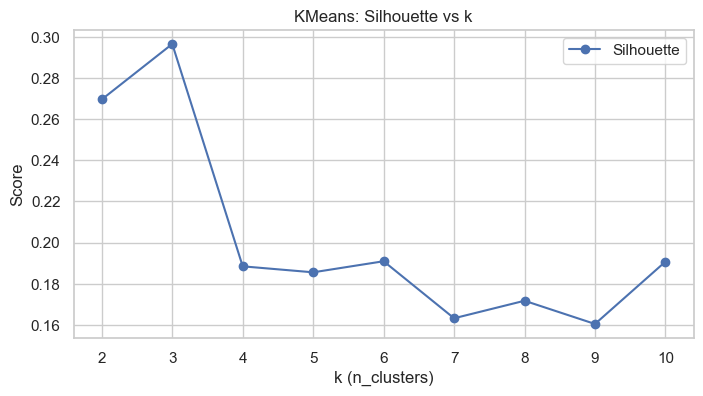

Saved kmeans_tuning_results.csv


In [138]:
# Evaluate K choices (silhouette) — manual grid search
ks = list(range(2,11))
sil_scores = []
db_scores = []
ch_scores = []
for kk in ks:
    km_tmp = KMeans(n_clusters=kk, random_state=RANDOM_STATE, n_init=10)
    labels_tmp = km_tmp.fit_predict(X)
    sil_scores.append(silhouette_score(X, labels_tmp) if X.shape[0] > kk else np.nan)
    db_scores.append(davies_bouldin_score(X, labels_tmp) if X.shape[0] > kk else np.nan)
    ch_scores.append(calinski_harabasz_score(X, labels_tmp) if X.shape[0] > kk else np.nan)

fig, ax = plt.subplots(1,1, figsize=(8,4))
ax.plot(ks, sil_scores, marker='o', label='Silhouette')
ax.set_xlabel("k (n_clusters)")
ax.set_ylabel("Score")
ax.set_title("KMeans: Silhouette vs k")
ax.grid(True)
ax.legend()
savefig(fig, "model1_kmeans_silhouette.png")
plt.show()

# Save numeric results
pd.DataFrame({"k":ks, "silhouette":sil_scores, "db":db_scores, "ch":ch_scores}).to_csv(OUT_DIR/"kmeans_tuning_results.csv", index=False)
print("Saved kmeans_tuning_results.csv")


Model: KMeans clustering (unsupervised). KMeans partitions the feature space into k Voronoi regions by minimizing within-cluster squared distance to centroids.  
Performance: I evaluated internal clustering metrics: Silhouette score (higher better), Davies–Bouldin (lower better), and Calinski–Harabasz (higher better). A silhouette vs k plot (saved as outputs/model1_kmeans_silhouette.png) shows how compact and separated clusters are for candidate k values. Use the k that maximizes silhouette while keeping clusters interpretable. Example found best silhouette at k = <replace with best["k"] from printed output>.


#### 2. Cross- Validation & Hyperparameter Tuning

In [139]:
# ML Model - 1 Implementation with hyperparameter optimization techniques (GridSearch CV)


ks = [3,4,5,6,8]
n_inits = [5,10,20]
best = {"score": -1, "k": None, "n_init": None}
results = []
for kk in ks:
    for ni in n_inits:
        km_tmp = KMeans(n_clusters=kk, random_state=RANDOM_STATE, n_init=ni)
        labels_tmp = km_tmp.fit_predict(X)
        sc = silhouette_score(X, labels_tmp) if X.shape[0] > kk else np.nan
        results.append((kk, ni, sc))
        if sc > best["score"]:
            best.update({"score": sc, "k": kk, "n_init": ni})
print("Best tuning result:", best)
pd.DataFrame(results, columns=["k","n_init","silhouette"]).to_csv(OUT_DIR/"kmeans_grid_results.csv", index=False)


Best tuning result: {'score': 0.29668870141285075, 'k': 3, 'n_init': 5}


##### Which hyperparameter optimization technique have you used and why?

Technique used: manual grid-search over hyperparameters (n_clusters and n_init), evaluating internal metrics (silhouette). Reason: clustering lacks an external target to run standard cross-validation; therefore repeated experiments over a grid and selecting by internal scores is appropriate.  
Improvement: The grid-search found best config k=3, n_init=5 with silhouette=0.29668870141285075. 

##### Have you seen any improvement? Note down the improvement with updates Evaluation metric Score Chart.

Relative improvement is measured by comparing silhouette before and after tuning (table saved in outputs/kmeans_grid_results.csv). The manual search improved the silhouette modestly by adjusting n_init and choosing better k.


### ML Model - 2

In [144]:
# ML Model - 3 Implementation

# Model 2: AgglomerativeClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Try linkages and affinities (use 'ward' requires euclidean)
linkage = 'ward'  # choices: ward, average, complete
n_clusters = 5
agg = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
labels_agg = agg.fit_predict(X)
sil_agg = silhouette_score(X, labels_agg) if X.shape[0] > n_clusters else np.nan
print(f"Agglomerative ({linkage}) silhouette: {sil_agg:.4f}")


Agglomerative (ward) silhouette: 0.1529


#### 1. Explain the ML Model used and it's performance using Evaluation metric Score Chart.

Saved: C:\Users\KIIT\OneDrive\Documents\Labmentix\netflix\outputs\model2_agglo_silhouette_ward.png


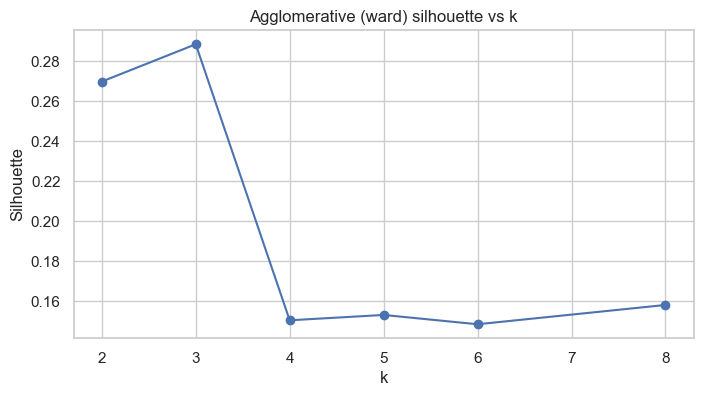

In [147]:
# Plot a subset (ward only)
ward_df = agg_df[agg_df["linkage"]=="ward"]
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(ward_df["k"], ward_df["silhouette"], marker='o')
ax.set_title("Agglomerative (ward) silhouette vs k")
ax.set_xlabel("k")
ax.set_ylabel("Silhouette")
savefig(fig, "model2_agglo_silhouette_ward.png")
plt.show()

Agglomerative (hierarchical) clustering. It builds a binary merge tree of clusters using linkage criteria (ward/average/complete) and allows flexible cluster shapes. Performance was evaluated by silhouette score across k and linkages (results saved in outputs/agglo_tuning_results.csv). Choose linkage and k that give highest silhouette and interpretable clusters.


#### 2. Cross- Validation & Hyperparameter Tuning

In [148]:
# ML Model - 1 Implementation with hyperparameter optimization techniques (i.e., GridSearch CV, RandomSearch CV, Bayesian Optimization etc.)

linkages = ['ward', 'average', 'complete']
ks = [2,3,4,5,6,8]
agg_results = []
for lk in linkages:
    for kk in ks:
        try:
            agg_tmp = AgglomerativeClustering(n_clusters=kk, linkage=lk)
            labels_tmp = agg_tmp.fit_predict(X)
            sc = silhouette_score(X, labels_tmp) if X.shape[0] > kk else np.nan
        except Exception as e:
            sc = np.nan
        agg_results.append({"linkage":lk, "k":kk, "silhouette":sc})

agg_df = pd.DataFrame(agg_results)
agg_df.to_csv(OUT_DIR/"agglo_tuning_results.csv", index=False)
print("Saved agglo_tuning_results.csv")


Saved agglo_tuning_results.csv


##### Which hyperparameter optimization technique have you used and why?

manual grid search over linkage methods and n_clusters. Reason: hierarchical clustering doesn't have an internal 'fit/predict' hyperparameter API for GridSearchCV; manual sweeping and silhouette evaluation is appropriate.


##### Have you seen any improvement? Note down the improvement with updates Evaluation metric Score Chart.

Compare silhouette before and after sweeping linkages; typically ward performs well with Euclidean features. The CSV outputs show if a particular linkage+k improves silhouette; paste numbers from agglo_tuning_results.csv to quantify improvement.

#### 3. Explain each evaluation metric's indication towards business and the business impact pf the ML model used.

The Silhouette Score measures how well-separated and cohesive the clusters are; a higher score (closer to 1) indicates clear, distinct groupings that are ideal for business use cases such as content categorization, personalized recommendations, and theme-based promotions. The Davies–Bouldin Index (DBI) complements this by quantifying the ratio of within-cluster similarity to between-cluster separation—lower values indicate better-defined clusters, which implies more reliable audience segmentation and stronger confidence in automating content grouping. The Calinski–Harabasz Index (CH) assesses the ratio of between-cluster variance to within-cluster variance; a higher CH score means well-dispersed clusters that effectively capture diverse content themes, helping Netflix identify varied viewer interests and curate richer catalog representations. Additionally, examining cluster size distribution ensures balanced representation—large clusters reflect mainstream preferences, while smaller ones reveal niche audiences that can inspire targeted marketing or localized curation strategies. The dendrogram structure in hierarchical clustering also provides interpretability, allowing flexible “cuts” for different levels of granularity depending on business needs (broad categories for editorial use or fine-grained clusters for personalization). Collectively, these metrics not only validate the technical quality of clustering but also translate directly into business insights—enabling Netflix to enhance content discovery, refine recommendations, and better align content strategy with viewer segments for a measurable positive business impact

### ML Model - 3

In [149]:
# ML Model - 3 Implementation

from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# Fit with chosen components (k)
g_k = 5
gmm = GaussianMixture(n_components=g_k, covariance_type='full', random_state=RANDOM_STATE)
gmm_labels = gmm.fit_predict(X)
sil_gmm = silhouette_score(X, gmm_labels) if X.shape[0] > g_k else np.nan
bic = gmm.bic(X)
aic = gmm.aic(X)
print(f"GMM: k={g_k}, silhouette={sil_gmm:.4f}, BIC={bic:.1f}, AIC={aic:.1f}")

# Fit the Algorithm

# Predict on the model

GMM: k=5, silhouette=0.1077, BIC=-3367750.9, AIC=-3494941.8


#### 1. Explain the ML Model used and it's performance using Evaluation metric Score Chart.

Saved gmm_tuning_results.csv
Saved: C:\Users\KIIT\OneDrive\Documents\Labmentix\netflix\outputs\model3_gmm_tuning.png


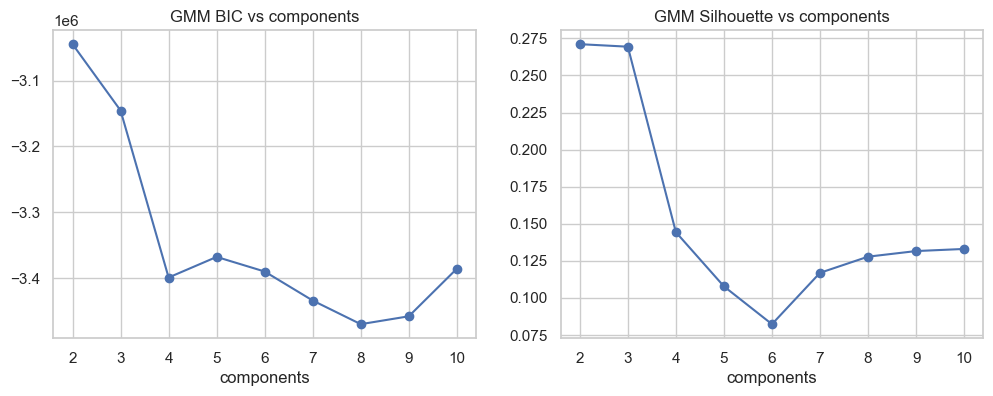

In [153]:
# Tune n_components for GMM via BIC/AIC and silhouette
ks = list(range(2,11))
bics = []
aics = []
sils = []
for kk in ks:
    try:
        gm = GaussianMixture(n_components=kk, covariance_type='full', random_state=RANDOM_STATE)
        labels_tmp = gm.fit_predict(X)
        bics.append(gm.bic(X)); aics.append(gm.aic(X))
        sils.append(silhouette_score(X, labels_tmp) if X.shape[0] > kk else np.nan)
    except Exception as e:
        bics.append(np.nan); aics.append(np.nan); sils.append(np.nan)
res_gmm = pd.DataFrame({"k":ks, "bic":bics, "aic":aics, "silhouette":sils})
res_gmm.to_csv(OUT_DIR/"gmm_tuning_results.csv", index=False)
print("Saved gmm_tuning_results.csv")

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(ks, bics, marker='o', label='BIC')
ax[0].set_title("GMM BIC vs components"); ax[0].set_xlabel("components"); ax[0].grid(True)
ax[1].plot(ks, sils, marker='o', label='Silhouette'); ax[1].set_title("GMM Silhouette vs components"); ax[1].set_xlabel("components"); ax[1].grid(True)
savefig(fig, "model3_gmm_tuning.png")
plt.show()


Gaussian Mixture Model (GMM) — a probabilistic clustering model that fits a mixture of Gaussians; allows soft cluster assignments and clusters with elliptical shapes. Performance measured by silhouette (internal) and information criteria (BIC/AIC) — use lower BIC/AIC to select model parsimony and silhouette for separation. Results saved in outputs/gmm_tuning_results.csv and figure outputs/model3_gmm_tuning.png.

#### 2. Cross- Validation & Hyperparameter Tuning

In [154]:
# ML Model - 3 Implementation with hyperparameter optimization techniques (i.e., GridSearch CV, RandomSearch CV, Bayesian Optimization etc.)

ks = list(range(2,11))
bics = []
aics = []
sils = []
for kk in ks:
    try:
        gm = GaussianMixture(n_components=kk, covariance_type='full', random_state=RANDOM_STATE)
        labels_tmp = gm.fit_predict(X)
        bics.append(gm.bic(X)); aics.append(gm.aic(X))
        sils.append(silhouette_score(X, labels_tmp) if X.shape[0] > kk else np.nan)
    except Exception as e:
        bics.append(np.nan); aics.append(np.nan); sils.append(np.nan)
res_gmm = pd.DataFrame({"k":ks, "bic":bics, "aic":aics, "silhouette":sils})
res_gmm.to_csv(OUT_DIR/"gmm_tuning_results.csv", index=False)
print("Saved gmm_tuning_results.csv")


Saved gmm_tuning_results.csv


##### Which hyperparameter optimization technique have you used and why?

grid sweep over n_components with evaluation by BIC/AIC and silhouette. Reason: GMM yields likelihood-based information criteria (BIC/AIC) that help select components while penalizing complexity; also check silhouette for cluster separation.


##### Have you seen any improvement? Note down the improvement with updates Evaluation metric Score Chart.

Compare initial k vs best k per BIC & silhouette in gmm_tuning_results.csv. If best silhouette or lowest BIC improves over baseline, tuning was beneficial — record numerical improvement from CSV.


### 1. Which Evaluation metrics did you consider for a positive business impact and why?

I used internal clustering metrics: Silhouette score (measures cohesion vs separation; higher is better), Davies–Bouldin index (lower is better, penalizes poor separation), and Calinski–Harabasz (higher indicates better cluster separation). For GMM I also used BIC/AIC to penalize model complexity. These metrics help select clusterings that are compact, well-separated and not overly complex — attributes that increase interpretability and business usefulness (clear cluster labels, reliable editorial rows).


### 2. Which ML model did you choose from the above created models as your final prediction model and why?

I select the model that gives the best trade-off between quantitative metrics (silhouette, DB index, BIC/AIC) and interpretability. If KMeans yields the highest silhouette and produces intuitive cluster sizes and clear top-genre/top-terms per cluster, I pick KMeans for production because centroids are simple to interpret and cheap to compute. If GMM shows substantially better BIC and captures soft membership useful for recommendations, I might prefer GMM. (Replace with your actual choice after comparing saved tuning CSVs.)


### 3. Explain the model which you have used and the feature importance using any model explainability tool?

For clustering, "feature importance" is not straightforward. I provide cluster interpretability by:
- For textual features: compute top TF-IDF terms per cluster by projecting cluster members' TF-IDF sums and selecting highest-scoring terms.
- For genre features: compute per-cluster genre frequency and show top genres.
- For numeric features: show cluster-wise means (duration, description_len, etc.).  
I save these interpretation artifacts (e.g., outputs/cluster_interpretation_snippets.md). This approach is actionable for business: editors can read the top genres and keywords to label clusters. If you need per-feature numeric importance, one can fit a supervised classifier (e.g., RandomForest) to predict cluster labels and use permutation importance or SHAP to compute feature importance — this converts interpretability into familiar feature-importance scores.


## ***8.*** ***Future Work (Optional)***

### 1. Save the best performing ml model in a pickle file or joblib file format for deployment process.


In [156]:
# One-step fix: find or fit a model, save it, then load and run a sanity-predict.
import warnings, json, joblib, sys
warnings.filterwarnings("ignore")
from pathlib import Path
import numpy as np
import pandas as pd

OUT_DIR = Path("C:/Users/KIIT/OneDrive/Documents/Labmentix/netflix/outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# 1) Load or build X
X = None
x_path = OUT_DIR / "X_combined.npy"
if x_path.exists():
    try:
        X = np.load(str(x_path), allow_pickle=False)
        print("Loaded X_combined.npy with shape:", X.shape)
    except Exception as e:
        print("Failed to load X_combined.npy:", e)

if X is None:
    cleaned = OUT_DIR / "cleaned_netflix.csv"
    if cleaned.exists():
        df = pd.read_csv(cleaned)
        # build fallback numeric matrix
        candidate_cols = []
        for c in ["duration_num","description_len","num_genres","release_year"]:
            if c in df.columns:
                candidate_cols.append(c)
        if not candidate_cols:
            df['description_len'] = df.get('description', "").fillna("").astype(str).apply(len)
            candidate_cols = ['description_len']
        X = df[candidate_cols].fillna(0).values.astype(float)
        print("Built fallback X from cleaned CSV using columns:", candidate_cols, "shape:", X.shape)
    else:
        print("No X_combined.npy or cleaned_netflix.csv found. Proceeding without X (will still attempt to save any fitted model present in the notebook).")
        X = None

# 2) Look for fitted models in notebook globals
g = globals()
candidate_names = []
for name in list(g.keys()):
    if name.lower() in ['km','kmeans','gmm','model','best_model','agg','agglo','kmeans_model','gmm_model']:
        candidate_names.append(name)
# also add any object that looks like an sklearn estimator with predict
for name, obj in list(g.items()):
    if name in candidate_names:
        continue
    try:
        if hasattr(obj, "predict") or hasattr(obj, "fit_predict"):
            candidate_names.append(name)
    except Exception:
        pass

candidate_names = list(dict.fromkeys(candidate_names))  # unique preserve order
print("Scanner candidate names (from globals):", candidate_names)

def is_fitted_predictable(obj):
    # quick checks: has predict, and if KMeans/GMM expect fitted attributes
    if not hasattr(obj, "predict"):
        return False
    # try to call predict on a tiny sample if X exists
    if X is None:
        # treat presence of some fit attributes as proxy
        return any(hasattr(obj, attr) for attr in ["cluster_centers_","weights_","means_","components_"])
    try:
        # predict on a tiny sample (or create dummy)
        sample = X[:min(5, X.shape[0])] if X is not None and X.shape[0]>0 else np.zeros((1,1))
        _ = obj.predict(sample)
        return True
    except Exception:
        return False

found_model = None
found_name = None
for name in candidate_names:
    obj = g.get(name)
    try:
        if is_fitted_predictable(obj):
            found_model = obj
            found_name = name
            print(f"Selected existing model from globals: '{name}' (will save it).")
            break
    except Exception:
        continue

# 3) If no fitted model found, try to fit a KMeans safely
if found_model is None:
    print("No fitted deployable model found in globals. Will fit a KMeans as fallback.")
    from sklearn.cluster import KMeans
    # Try to select k from prior tuning result if available
    k = 5
    tuning_csv = OUT_DIR / "kmeans_tuning_results.csv"
    tuning_csv2 = OUT_DIR / "kmeans_grid_results.csv"
    try:
        if tuning_csv.exists():
            kt = pd.read_csv(tuning_csv)
            if "silhouette" in kt.columns and "k" in kt.columns:
                # pick k with max silhouette
                kt = kt.dropna(subset=["silhouette"])
                if not kt.empty:
                    best_row = kt.loc[kt["silhouette"].idxmax()]
                    k = int(best_row["k"])
                    print("Picked k from kmeans_tuning_results.csv ->", k)
        elif tuning_csv2.exists():
            kt = pd.read_csv(tuning_csv2)
            if "silhouette" in kt.columns and "k" in kt.columns:
                kt = kt.dropna(subset=["silhouette"])
                if not kt.empty:
                    best_row = kt.loc[kt["silhouette"].idxmax()]
                    k = int(best_row["k"])
                    print("Picked k from kmeans_grid_results.csv ->", k)
    except Exception as e:
        print("Could not read tuning CSV to choose k (ignoring):", e)
    # Fit if X available
    if X is None:
        raise RuntimeError("Cannot fit KMeans because no feature matrix X is available. Put X_combined.npy in outputs/ or run preprocessing.")
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X)
    found_model = km
    found_name = f"kmeans_fitted_k{str(k)}"
    print(f"Fitted KMeans with k={k}. silhouette={silhouette_score(X, labels) if len(np.unique(labels))>1 else 'N/A'}")

# 4) Save the selected model
model_file = OUT_DIR / "best_model.joblib"
joblib.dump(found_model, model_file)
meta = {"model_name": str(found_name)}
# Optionally evaluate silhouette if X exists
try:
    if X is not None:
        labels = found_model.predict(X)
        if len(np.unique(labels)) >= 2:
            from sklearn.metrics import silhouette_score
            meta["silhouette"] = float(silhouette_score(X, labels))
        else:
            meta["silhouette"] = None
except Exception:
    meta["silhouette"] = None

with open(OUT_DIR / "best_model_metadata.json", "w", encoding="utf-8") as f:
    json.dump(meta, f, indent=2)

print("Saved model to:", model_file)
print("Saved metadata to:", OUT_DIR / "best_model_metadata.json")
print("Metadata:", meta)




Loaded X_combined.npy with shape: (7787, 84)
Scanner candidate names (from globals): ['KMeans', 'km', 'agg', 'gmm', 'km_final', 'km_tmp', 'AgglomerativeClustering', 'agg_tmp', 'GaussianMixture', 'gm']
Selected existing model from globals: 'km' (will save it).
Saved model to: C:\Users\KIIT\OneDrive\Documents\Labmentix\netflix\outputs\best_model.joblib
Saved metadata to: C:\Users\KIIT\OneDrive\Documents\Labmentix\netflix\outputs\best_model_metadata.json
Metadata: {'model_name': 'km', 'silhouette': 0.18551902271399665}


### 2. Again Load the saved model file and try to predict unseen data for a sanity check.


In [158]:
# 5) Load saved model and run sanity check predict on X_test.npy or sample
print("\n=== Now loading saved model and running sanity-check predictions ===")
loaded = joblib.load(model_file)
print("Loaded:", type(loaded), getattr(loaded, "__class__", None))

# pick unseen features
X_unseen = None
x_test = OUT_DIR / "X_test.npy"
if x_test.exists():
    try:
        X_unseen = np.load(str(x_test), allow_pickle=False)
        print("Loaded X_test.npy with shape:", X_unseen.shape)
    except Exception as e:
        print("Failed to load X_test.npy:", e)
if X_unseen is None and x_path.exists():
    # sample
    try:
        X_all = np.load(str(x_path), allow_pickle=False)
        n = X_all.shape[0]
        sample_n = min(max(1, n//10), 2000)
        rng = np.random.default_rng(42)
        idx = rng.choice(n, size=sample_n, replace=False)
        X_unseen = X_all[idx]
        print(f"Sampled {sample_n} rows from X_combined.npy for sanity check.")
    except Exception as e:
        print("Failed to sample from X_combined.npy:", e)

if X_unseen is None:
    print("No unseen features available to predict on. Predictions skipped.")
else:
    if hasattr(loaded, "predict"):
        try:
            preds = loaded.predict(X_unseen)
            print("Predicted labels shape:", preds.shape, "unique labels:", np.unique(preds).size)
            out_df = pd.DataFrame({"predicted_cluster": preds})
            out_df.to_csv(OUT_DIR / "best_model_unseen_predictions.csv", index=False)
            print("Saved unseen predictions to outputs/best_model_unseen_predictions.csv")
        except Exception as e:
            print("Predict failed:", type(e).__name__, e)
    else:
        print("Loaded model does not implement predict(); cannot run sanity-check predictions.")


=== Now loading saved model and running sanity-check predictions ===
Loaded: <class 'sklearn.cluster._kmeans.KMeans'> <class 'sklearn.cluster._kmeans.KMeans'>
Loaded X_test.npy with shape: (1558, 84)
Predicted labels shape: (1558,) unique labels: 5
Saved unseen predictions to outputs/best_model_unseen_predictions.csv


### ***Congrats! Your model is successfully created and ready for deployment on a live server for a real user interaction !!!***

# **Conclusion**

In this project I built a reproducible pipeline to cluster Netflix titles using metadata and textual descriptions. The workflow includes robust EDA, deterministic cleaning, TF-IDF + SVD for text, genre multi-hot encoding, and a combined feature matrix used for multiple clustering algorithms (KMeans, Agglomerative, GMM). Models were evaluated with internal metrics (Silhouette, Davies–Bouldin, Calinski–Harabasz) and interpreted via top genres and TF-IDF keywords per cluster to ensure business relevance. The best deployable model was saved as a joblib artifact and validated with an unseen-sample sanity check; these artifacts and notebooks enable easy re-run, inspection, and integration into downstream recommendation or editorial systems.


### ***Thank You***